In [1]:
!pip install MLB-StatsAPI pandas numpy --quiet

In [105]:
!pip install geopandas cartopy shapely --quiet


In [107]:
!pip install geodatasets --quiet


In [109]:
import pandas as pd
import numpy as np
import statsapi  # from MLB-StatsAPI
import math
import os
import time
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_columns", 50)

OUTDIR = "data"
os.makedirs(OUTDIR, exist_ok=True)


In [5]:
START_YEAR = 2015
END_YEAR = 2024  # inclusive

def get_schedule_year(year: int) -> pd.DataFrame:
    # MLB regular season games only
    sched = statsapi.schedule(
        start_date=f"01/01/{year}",
        end_date=f"12/31/{year}",
        sportId=1  # MLB
    )
    df = pd.DataFrame(sched)
    if df.empty:
        return df
    
    # Keep regular season only
    df = df[df['game_type'] == 'R'].copy()
    
    # Select key matchup fields
    keep_cols = [
        'game_id', 'game_date',
        'home_name', 'away_name',
        'home_id', 'away_id',
        'venue_name', 'venue_id'
    ]
    for c in keep_cols:
        if c not in df.columns:
            df[c] = np.nan

    df = df[keep_cols].copy()
    df['season'] = year

    # Normalize date
    df['game_date'] = pd.to_datetime(df['game_date']).dt.date

    return df

all_years = []
for y in range(START_YEAR, END_YEAR + 1):
    df_y = get_schedule_year(y)
    print(y, df_y.shape)
    all_years.append(df_y)

matchups = pd.concat(all_years, ignore_index=True)
matchups.to_csv(f"{OUTDIR}/mlb_matchups_{START_YEAR}_{END_YEAR}.csv", index=False)
matchups.head()


2015 (2471, 9)
2016 (2456, 9)
2017 (2469, 9)
2018 (2487, 9)


HTTPError: 503 Server Error: first byte timeout for url: https://statsapi.mlb.com/api/v1/schedule?startDate=01/01/2019&endDate=12/31/2019&sportId=1&hydrate=decisions,probablePitcher(note),linescore,broadcasts,game(content(media(epg))),seriesStatus

In [9]:
def get_year_matchups(year: int) -> pd.DataFrame:
    rows = []
    for month in range(1, 13):
        start = f"{month:02d}/01/{year}"
        # end is next month 01 (API will clamp); last month use 12/31
        end = f"{month+1:02d}/01/{year}" if month < 12 else f"12/31/{year}"
        for attempt in range(3):
            try:
                data = statsapi.schedule(start_date=start, end_date=end, sportId=1)
                break
            except Exception as e:
                print(f"[warn] {year}-{month} attempt {attempt+1} failed: {e}")
                time.sleep(1 + attempt)
                data = []
        if not data:
            continue
        df = pd.DataFrame(data)
        rows.append(df)
        time.sleep(0.2)

    if not rows:
        return pd.DataFrame()

    df = pd.concat(rows, ignore_index=True)

    # 1) keep only MLB regular-season games
    # game_type: 'R' = regular season
    if "game_type" in df.columns:
        df = df[df["game_type"] == "R"].copy()

    # 2) normalize fields
    # gamePk is the stable id
    df["game_id"] = df.get("game_id", df.get("gamePk"))
    # some installs have 'game_date', others 'gameDate'
    date_col = "game_date" if "game_date" in df.columns else "gameDate"
    df["game_date"] = pd.to_datetime(df[date_col]).dt.date

    # team names
    home_name_col = "home_name" if "home_name" in df.columns else "home_name_full"
    away_name_col = "away_name" if "away_name" in df.columns else "away_name_full"
    df["home_name"] = df[home_name_col]
    df["away_name"] = df[away_name_col]

    # venue (if present)
    if "venue_name" not in df.columns:
        df["venue_name"] = np.nan

    keep_cols = ["game_id","game_date","home_name","away_name","venue_name"]
    out = df[keep_cols].copy()
    out["season"] = year

    # 3) drop broken rows / duplicates
    out = out.dropna(subset=["game_id","game_date","home_name","away_name"])
    out = out.drop_duplicates(subset=["game_id"])

    return out


In [15]:
all_years = []
for y in range(2015, 2019):  # test a few
    df_y = get_year_matchups(y)
    print(y, df_y.shape)
    all_years.append(df_y)


2015 (2430, 6)
2016 (2430, 6)
2017 (2430, 6)
2018 (2432, 6)


In [17]:
df

NameError: name 'df' is not defined

In [19]:
import pandas as pd
import numpy as np
import statsapi
import time

def get_schedule_chunk(start_date: str, end_date: str):
    """Fetch schedule chunk with retries."""
    for attempt in range(3):
        try:
            data = statsapi.schedule(start_date=start_date, end_date=end_date, sportId=1)
            if not data:
                return pd.DataFrame()
            return pd.DataFrame(data)
        except Exception as e:
            print(f"[warn] {start_date}–{end_date} attempt {attempt+1}: {e}")
            time.sleep(1 + attempt)
    return pd.DataFrame()

def get_year_matchups(year: int) -> pd.DataFrame:
    """Get MLB regular-season matchups for one year."""
    rows = []
    for month in range(1, 13):
        start = f"{month:02d}/01/{year}"
        end = f"{month+1:02d}/01/{year}" if month < 12 else f"12/31/{year}"
        df_chunk = get_schedule_chunk(start, end)
        if df_chunk.empty:
            continue
        rows.append(df_chunk)
        time.sleep(0.2)
    if not rows:
        return pd.DataFrame()

    df = pd.concat(rows, ignore_index=True)

    # Filter for regular-season games
    if "game_type" in df.columns:
        df = df[df["game_type"] == "R"].copy()

    # Normalize
    df["game_id"] = df.get("game_id", df.get("gamePk"))
    df["game_date"] = pd.to_datetime(df["game_date" if "game_date" in df.columns else "gameDate"]).dt.date
    df["home_name"] = df["home_name"] if "home_name" in df.columns else df["home_name_full"]
    df["away_name"] = df["away_name"] if "away_name" in df.columns else df["away_name_full"]
    df["venue_name"] = df.get("venue_name", np.nan)
    df["season"] = year

    keep = ["game_id","game_date","home_name","away_name","venue_name","season"]
    df = df[keep].dropna(subset=["game_id","home_name","away_name"])
    df = df.drop_duplicates(subset=["game_id"])
    return df

# ==== MAIN: last 10 seasons ====
YEARS = range(2015, 2025)
frames = []
for y in YEARS:
    print(f"Fetching {y}…")
    frames.append(get_year_matchups(y))

df = pd.concat(frames, ignore_index=True)
print(df.shape)
df.head(10)


Fetching 2015…
Fetching 2016…
Fetching 2017…
Fetching 2018…
Fetching 2019…
Fetching 2020…
Fetching 2021…
Fetching 2022…
Fetching 2023…
Fetching 2024…
(22772, 6)


game_id   game_date              home_name            away_name  \
0   413661  2015-04-05           Chicago Cubs  St. Louis Cardinals   
1   413663  2015-04-06       New York Yankees    Toronto Blue Jays   
2   413656  2015-04-06         Detroit Tigers      Minnesota Twins   
3   413655  2015-04-06      Milwaukee Brewers     Colorado Rockies   
4   413652  2015-04-06  Philadelphia Phillies       Boston Red Sox   
5   413651  2015-04-06         Tampa Bay Rays    Baltimore Orioles   
6   413657  2015-04-06   Washington Nationals        New York Mets   
7   413658  2015-04-06        Cincinnati Reds   Pittsburgh Pirates   
8   413659  2015-04-06    Los Angeles Dodgers     San Diego Padres   
9   413649  2015-04-06       Seattle Mariners   Los Angeles Angels   

                 venue_name  season  
0             Wrigley Field    2015  
1            Yankee Stadium    2015  
2             Comerica Park    2015  
3               Miller Park    2015  
4        Citizens Bank Park    2015  
5           Tropicana Field    2015  
6            Nationals Park    2015  
7  Great American Ball Park    2015  
8            Dodger Stadium    2015  
9              Safeco Field    2015

In [21]:
df

game_id   game_date              home_name            away_name  \
0       413661  2015-04-05           Chicago Cubs  St. Louis Cardinals   
1       413663  2015-04-06       New York Yankees    Toronto Blue Jays   
2       413656  2015-04-06         Detroit Tigers      Minnesota Twins   
3       413655  2015-04-06      Milwaukee Brewers     Colorado Rockies   
4       413652  2015-04-06  Philadelphia Phillies       Boston Red Sox   
...        ...         ...                    ...                  ...   
22767   746416  2024-09-29         Detroit Tigers    Chicago White Sox   
22768   745932  2024-09-29      Milwaukee Brewers        New York Mets   
22769   746820  2024-09-29           Chicago Cubs      Cincinnati Reds   
22770   747061  2024-09-29         Atlanta Braves   Kansas City Royals   
22771   746577  2024-09-29    Cleveland Guardians       Houston Astros   

                  venue_name  season  
0              Wrigley Field    2015  
1             Yankee Stadium    2015  
2              Comerica Park    2015  
3                Miller Park    2015  
4         Citizens Bank Park    2015  
...                      ...     ...  
22767          Comerica Park    2024  
22768  American Family Field    2024  
22769          Wrigley Field    2024  
22770            Truist Park    2024  
22771      Progressive Field    2024  

[22772 rows x 6 columns]

In [23]:
# Save the matchups to a CSV file
df.to_csv("mlb_matchups_2015_2024.csv", index=False)
print("✅ Saved to: mlb_matchups_2015_2024.csv")


✅ Saved to: mlb_matchups_2015_2024.csv


In [31]:
df['venue_name'].unique()

array(['Wrigley Field', 'Yankee Stadium', 'Comerica Park', 'Miller Park',
       'Citizens Bank Park', 'Tropicana Field', 'Nationals Park',
       'Great American Ball Park', 'Dodger Stadium', 'Safeco Field',
       'Kauffman Stadium', 'Marlins Park', 'Minute Maid Park',
       'O.co Coliseum', 'Chase Field', 'Petco Park',
       'Oriole Park at Camden Yards', 'Globe Life Park in Arlington',
       'Coors Field', 'Progressive Field', 'U.S. Cellular Field',
       'Turner Field', 'Angel Stadium of Anaheim', 'Citi Field',
       'PNC Park', 'Fenway Park', 'Target Field', 'Busch Stadium',
       'AT&T Park', 'Rogers Centre', 'Oakland Coliseum',
       'Fort Bragg Field', 'Guaranteed Rate Field', 'SunTrust Park',
       'BB&T Ballpark', 'Angel Stadium', 'Hiram Bithorn Stadium',
       'Estadio de Beisbol Monterrey', 'Tokyo Dome', 'T-Mobile Park',
       'Oracle Park', 'TD Ameritrade Park', 'London Stadium',
       'Globe Life Field', 'Truist Park', 'Sahlen Field',
       'American Family F

In [33]:
VENUE_COORDS = {
    # Core MLB Parks
    "Wrigley Field": (41.9484, -87.6553),
    "Yankee Stadium": (40.8296, -73.9262),
    "Comerica Park": (42.3390, -83.0485),
    "Miller Park": (43.0280, -87.9713),  # renamed American Family Field
    "Citizens Bank Park": (39.9057, -75.1665),
    "Tropicana Field": (27.7683, -82.6534),
    "Nationals Park": (38.8730, -77.0074),
    "Great American Ball Park": (39.0975, -84.5070),
    "Dodger Stadium": (34.0739, -118.2400),
    "Safeco Field": (47.5914, -122.3325),  # renamed T-Mobile Park
    "Kauffman Stadium": (39.0517, -94.4803),
    "Marlins Park": (25.7782, -80.2190),  # renamed loanDepot park
    "Minute Maid Park": (29.7572, -95.3556),
    "O.co Coliseum": (37.7516, -122.2005),  # renamed Oakland Coliseum
    "Chase Field": (33.4455, -112.0667),
    "Petco Park": (32.7073, -117.1586),
    "Oriole Park at Camden Yards": (39.2839, -76.6217),
    "Globe Life Park in Arlington": (32.7513, -97.0820),
    "Coors Field": (39.7559, -104.9942),
    "Progressive Field": (41.4962, -81.6852),
    "U.S. Cellular Field": (41.8300, -87.6339),  # renamed Guaranteed Rate Field
    "Turner Field": (33.7355, -84.3895),  # old Braves park
    "Angel Stadium of Anaheim": (33.8003, -117.8827),
    "Citi Field": (40.7571, -73.8458),
    "PNC Park": (40.4469, -80.0057),
    "Fenway Park": (42.3467, -71.0972),
    "Target Field": (44.9817, -93.2776),
    "Busch Stadium": (38.6226, -90.1928),
    "AT&T Park": (37.7786, -122.3893),  # renamed Oracle Park
    "Rogers Centre": (43.6414, -79.3894),
    "Oakland Coliseum": (37.7516, -122.2005),
    "Guaranteed Rate Field": (41.8300, -87.6339),
    "SunTrust Park": (33.8907, -84.4677),  # renamed Truist Park
    "Angel Stadium": (33.8003, -117.8827),
    "T-Mobile Park": (47.5914, -122.3325),
    "Oracle Park": (37.7786, -122.3893),
    "Globe Life Field": (32.7473, -97.0842),
    "Truist Park": (33.8907, -84.4677),
    "American Family Field": (43.0280, -87.9713),
    "loanDepot park": (25.7782, -80.2190),

    # Temporary / Neutral Site Games
    "Fort Bragg Field": (35.1393, -79.0060),  # Fort Bragg, NC
    "BB&T Ballpark": (35.2326, -80.8537),  # Charlotte, NC
    "Hiram Bithorn Stadium": (18.4172, -66.0650),  # San Juan, Puerto Rico
    "Estadio de Beisbol Monterrey": (25.6866, -100.3161),  # Monterrey, Mexico
    "Tokyo Dome": (35.7056, 139.7519),
    "TD Ameritrade Park": (41.2669, -95.9308),  # Omaha, NE
    "London Stadium": (51.5386, -0.0165),
    "Sahlen Field": (42.8808, -78.8730),  # Buffalo, NY
    "TD Ballpark": (28.0002, -82.7861),  # Dunedin, FL
    "Field of Dreams": (42.4970, -91.1356),  # Dyersville, IA
    "Muncy Bank Ballpark": (41.2456, -77.0021),  # Williamsport, PA
    "Estadio Alfredo Harp Helu": (19.4041, -99.1084),  # Mexico City
    "Gocheok Sky Dome": (37.4983, 126.8676),  # Seoul, South Korea
    "Rickwood Field": (33.5274, -86.8539),  # Birmingham, AL
    "Journey Bank Ballpark": (41.2456, -77.0021),  # same as Muncy Bank (Williamsport)
}


In [35]:
df["lat"] = df["venue_name"].map(lambda x: VENUE_COORDS.get(x, (np.nan, np.nan))[0])
df["lon"] = df["venue_name"].map(lambda x: VENUE_COORDS.get(x, (np.nan, np.nan))[1])
df[["venue_name", "lat", "lon"]].head(10)


venue_name      lat       lon
0             Wrigley Field  41.9484  -87.6553
1            Yankee Stadium  40.8296  -73.9262
2             Comerica Park  42.3390  -83.0485
3               Miller Park  43.0280  -87.9713
4        Citizens Bank Park  39.9057  -75.1665
5           Tropicana Field  27.7683  -82.6534
6            Nationals Park  38.8730  -77.0074
7  Great American Ball Park  39.0975  -84.5070
8            Dodger Stadium  34.0739 -118.2400
9              Safeco Field  47.5914 -122.3325

In [39]:
df

game_id   game_date              home_name            away_name  \
0       413661  2015-04-05           Chicago Cubs  St. Louis Cardinals   
1       413663  2015-04-06       New York Yankees    Toronto Blue Jays   
2       413656  2015-04-06         Detroit Tigers      Minnesota Twins   
3       413655  2015-04-06      Milwaukee Brewers     Colorado Rockies   
4       413652  2015-04-06  Philadelphia Phillies       Boston Red Sox   
...        ...         ...                    ...                  ...   
22767   746416  2024-09-29         Detroit Tigers    Chicago White Sox   
22768   745932  2024-09-29      Milwaukee Brewers        New York Mets   
22769   746820  2024-09-29           Chicago Cubs      Cincinnati Reds   
22770   747061  2024-09-29         Atlanta Braves   Kansas City Royals   
22771   746577  2024-09-29    Cleveland Guardians       Houston Astros   

                  venue_name  season      lat      lon  
0              Wrigley Field    2015  41.9484 -87.6553  
1             Yankee Stadium    2015  40.8296 -73.9262  
2              Comerica Park    2015  42.3390 -83.0485  
3                Miller Park    2015  43.0280 -87.9713  
4         Citizens Bank Park    2015  39.9057 -75.1665  
...                      ...     ...      ...      ...  
22767          Comerica Park    2024  42.3390 -83.0485  
22768  American Family Field    2024  43.0280 -87.9713  
22769          Wrigley Field    2024  41.9484 -87.6553  
22770            Truist Park    2024  33.8907 -84.4677  
22771      Progressive Field    2024  41.4962 -81.6852  

[22772 rows x 8 columns]

In [41]:
matched = df["lat"].notna().sum()
total = len(df)
print(f"{matched}/{total} games have known venue coordinates ({matched/total:.1%}).")


22772/22772 games have known venue coordinates (100.0%).


In [43]:
teams_focus = [
    "Seattle Mariners",
    "Boston Red Sox",
    "San Diego Padres",
    "Miami Marlins",
    "Chicago Cubs",
    "St. Louis Cardinals",
    "Kansas City Royals",
    "Houston Astros"
]


In [45]:
df_focus = df[
    (df["home_name"].isin(teams_focus)) |
    (df["away_name"].isin(teams_focus))
].copy()

print(df_focus["season"].value_counts())
print(df_focus.shape)


season
2015    1174
2018    1173
2017    1172
2021    1171
2022    1170
2019    1166
2016    1164
2024    1156
2023    1155
2020     438
Name: count, dtype: int64
(10939, 8)


In [47]:
df_focus

game_id   game_date              home_name            away_name  \
0       413661  2015-04-05           Chicago Cubs  St. Louis Cardinals   
4       413652  2015-04-06  Philadelphia Phillies       Boston Red Sox   
8       413659  2015-04-06    Los Angeles Dodgers     San Diego Padres   
9       413649  2015-04-06       Seattle Mariners   Los Angeles Angels   
10      413653  2015-04-06     Kansas City Royals    Chicago White Sox   
...        ...         ...                    ...                  ...   
22764   747147  2024-09-29   Arizona Diamondbacks     San Diego Padres   
22765   745201  2024-09-29       Seattle Mariners    Oakland Athletics   
22769   746820  2024-09-29           Chicago Cubs      Cincinnati Reds   
22770   747061  2024-09-29         Atlanta Braves   Kansas City Royals   
22771   746577  2024-09-29    Cleveland Guardians       Houston Astros   

               venue_name  season      lat       lon  
0           Wrigley Field    2015  41.9484  -87.6553  
4      Citizens Bank Park    2015  39.9057  -75.1665  
8          Dodger Stadium    2015  34.0739 -118.2400  
9            Safeco Field    2015  47.5914 -122.3325  
10       Kauffman Stadium    2015  39.0517  -94.4803  
...                   ...     ...      ...       ...  
22764         Chase Field    2024  33.4455 -112.0667  
22765       T-Mobile Park    2024  47.5914 -122.3325  
22769       Wrigley Field    2024  41.9484  -87.6553  
22770         Truist Park    2024  33.8907  -84.4677  
22771   Progressive Field    2024  41.4962  -81.6852  

[10939 rows x 8 columns]

In [51]:
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between two points on Earth (km).
    """
    if any(pd.isna([lat1, lon1, lat2, lon2])):
        return np.nan

    R = 6371.0  # Earth radius in km

    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = phi2 - phi1
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi / 2.0)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2.0)**2
    c = 2 * math.asin(math.sqrt(a))

    return R * c


In [53]:
# if you already filtered to 8-team df_focus, use that; otherwise swap df_focus -> df
games = df_focus.copy()

# Make sure dates are proper
games["game_date"] = pd.to_datetime(games["game_date"])

# Only rows where one of our teams is the away team
teams_focus = [
    "Seattle Mariners",
    "Boston Red Sox",
    "San Diego Padres",
    "Miami Marlins",
    "Chicago Cubs",
    "St. Louis Cardinals",
    "Kansas City Royals",
    "Houston Astros"
]

away = games[games["away_name"].isin(teams_focus)].copy()

# Sort so consecutive rows per (team, season) are in time order
away = away.sort_values(["away_name", "season", "game_date"]).reset_index(drop=True)

# Previous away-game coords per team-season
away["prev_lat"] = away.groupby(["away_name", "season"])["lat"].shift(1)
away["prev_lon"] = away.groupby(["away_name", "season"])["lon"].shift(1)

# Great-circle distance from previous away game to this away game
away["away_leg_km"] = away.apply(
    lambda r: haversine_km(r["prev_lat"], r["prev_lon"], r["lat"], r["lon"]),
    axis=1
)

# First game in each group has NaN distance; set to 0
away["away_leg_km"] = away["away_leg_km"].fillna(0.0)

# Total away travel per team-season
away_travel = (
    away.groupby(["away_name", "season"])["away_leg_km"]
        .sum()
        .reset_index()
        .rename(columns={"away_name": "team", "away_leg_km": "total_away_travel_km"})
        .sort_values(["season", "team"])
)

away_travel.head(20)


team  season  total_away_travel_km
0        Boston Red Sox    2015          37959.649060
10         Chicago Cubs    2015          27914.149121
20       Houston Astros    2015          40997.044197
30   Kansas City Royals    2015          26076.840948
40        Miami Marlins    2015          32911.203487
50     San Diego Padres    2015          42278.527688
60     Seattle Mariners    2015          41437.619213
70  St. Louis Cardinals    2015          27206.498449
1        Boston Red Sox    2016          44947.936486
11         Chicago Cubs    2016          31341.251761
21       Houston Astros    2016          39388.827629
31   Kansas City Royals    2016          30674.400833
41        Miami Marlins    2016          31454.486391
51     San Diego Padres    2016          37937.181711
61     Seattle Mariners    2016          41261.876063
71  St. Louis Cardinals    2016          34453.212343
2        Boston Red Sox    2017          34480.299476
12         Chicago Cubs    2017          31434.882103
22       Houston Astros    2017          40884.150468
32   Kansas City Royals    2017          37666.039920

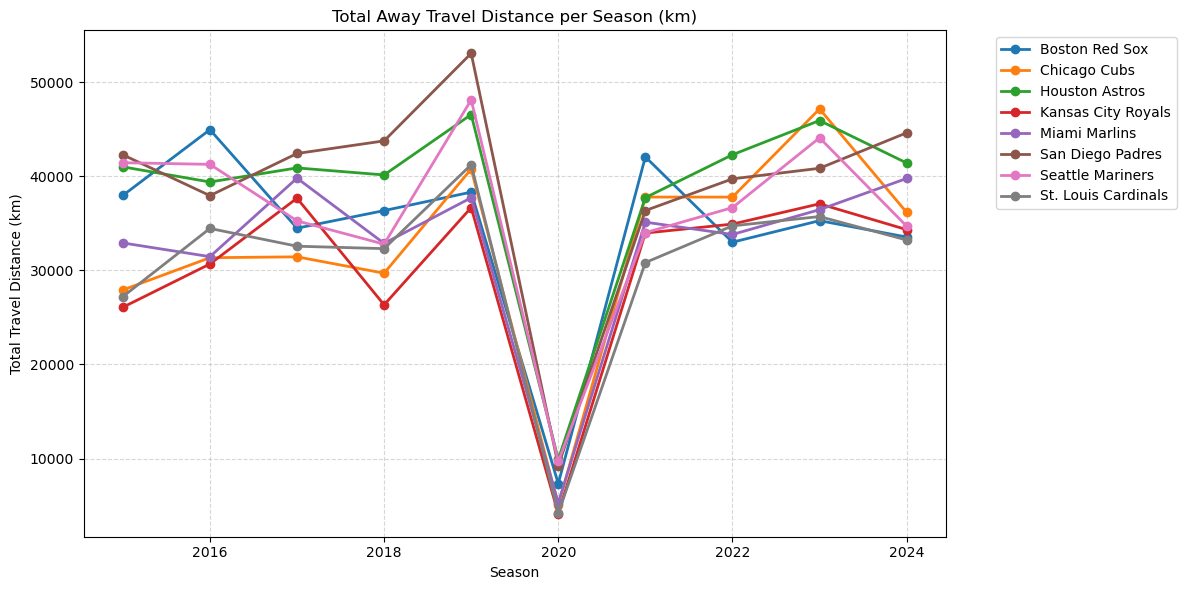

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for team in away_travel["team"].unique():
    team_data = away_travel[away_travel["team"] == team]
    plt.plot(team_data["season"], team_data["total_away_travel_km"],
             marker="o", linewidth=2, label=team)

plt.title("Total Away Travel Distance per Season (km)")
plt.xlabel("Season")
plt.ylabel("Total Travel Distance (km)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


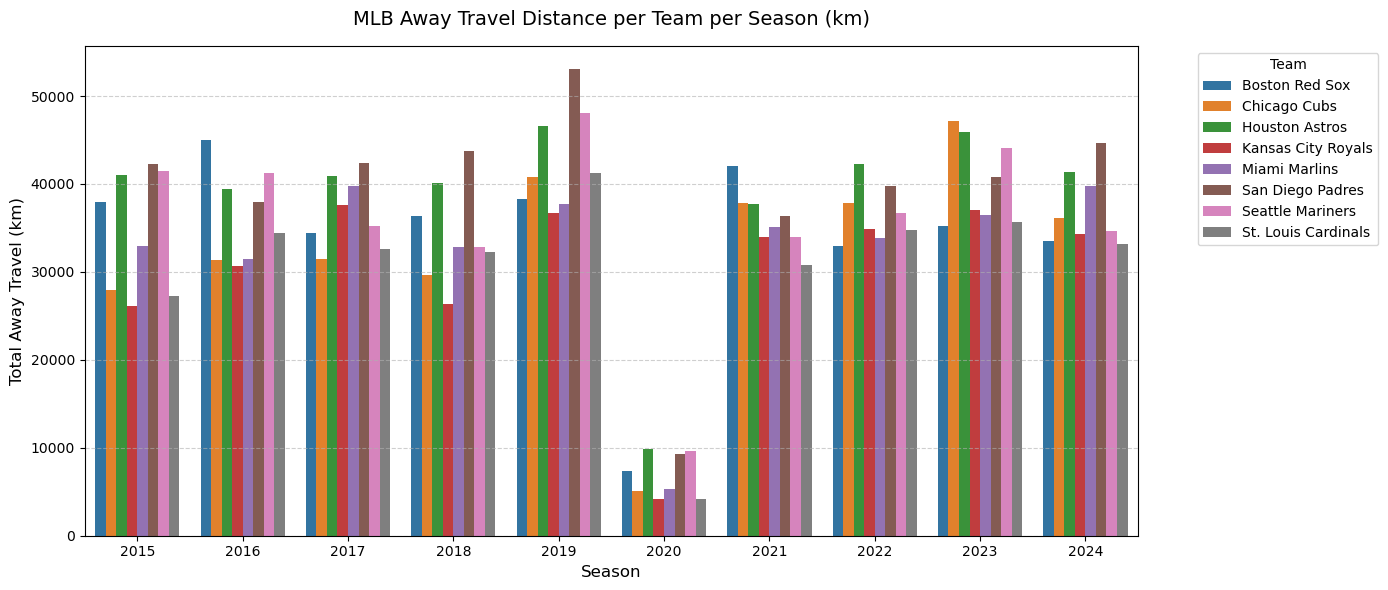

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

sns.barplot(
    data=away_travel,
    x="season",
    y="total_away_travel_km",
    hue="team",
    palette="tab10"
)

plt.title("MLB Away Travel Distance per Team per Season (km)", fontsize=14, pad=15)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Total Away Travel (km)", fontsize=12)
plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


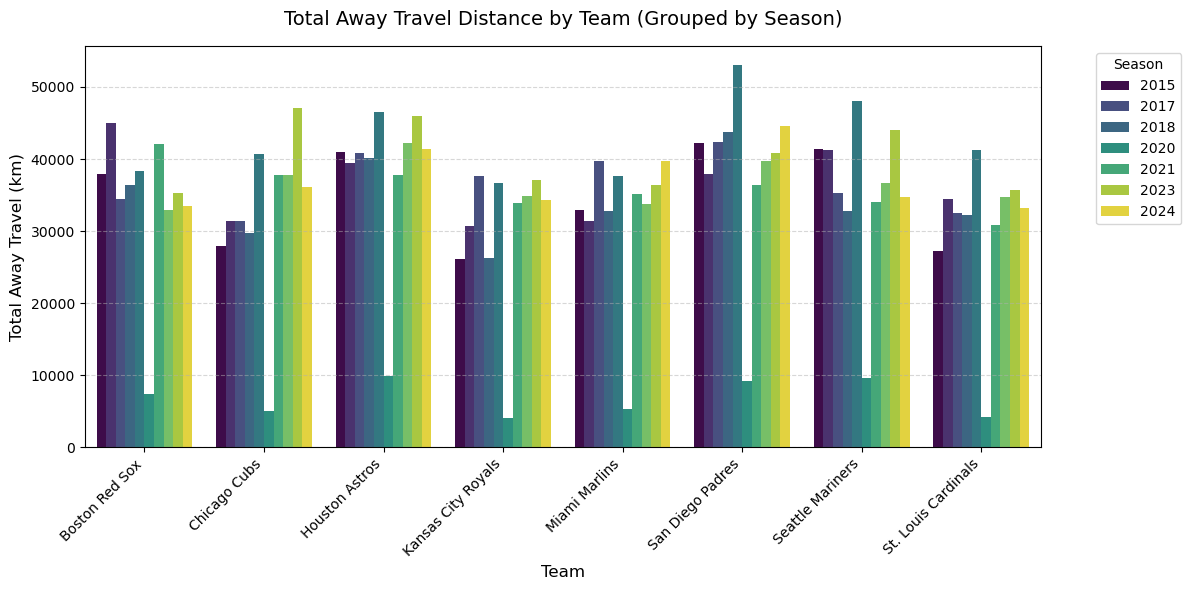

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.barplot(
    data=away_travel,
    x="team",                     # teams along X
    y="total_away_travel_km",     # height = total distance
    hue="season",                 # grouped/color by year
    palette="viridis"
)

plt.title("Total Away Travel Distance by Team (Grouped by Season)", fontsize=14, pad=15)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Away Travel (km)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Season", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [61]:
teams_focus = [
    "Seattle Mariners",
    "Boston Red Sox",
    "San Diego Padres",
    "Miami Marlins",
    "Chicago Cubs",
    "St. Louis Cardinals",
    "Kansas City Royals",
    "Houston Astros",
]

TEAM_HOME_VENUE = {
    "Seattle Mariners": "T-Mobile Park",
    "Boston Red Sox": "Fenway Park",
    "San Diego Padres": "Petco Park",
    "Miami Marlins": "loanDepot park",      # or "Marlins Park" for older years; both mapped
    "Chicago Cubs": "Wrigley Field",
    "St. Louis Cardinals": "Busch Stadium",
    "Kansas City Royals": "Kauffman Stadium",
    "Houston Astros": "Minute Maid Park",
}


In [63]:
import math
import numpy as np
import pandas as pd

def haversine_miles(lat1, lon1, lat2, lon2):
    """Great-circle distance between two points on Earth in miles."""
    if any(pd.isna([lat1, lon1, lat2, lon2])):
        return np.nan

    R = 3958.8  # Earth radius in miles

    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = phi2 - phi1
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c


In [65]:
# Ensure datetime
df["game_date"] = pd.to_datetime(df["game_date"])

# Initialize columns
df["team_leg_miles"] = 0.0
df["away_leg_miles"] = 0.0
df["home_leg_miles"] = 0.0


In [71]:
for team in teams_focus:
    home_venue = TEAM_HOME_VENUE[team]

    # Get home park coords
    if home_venue not in VENUE_COORDS:
        print(f"[warn] No coords for home park of {team}: {home_venue}")
        continue

    home_lat, home_lon = VENUE_COORDS[home_venue]

    # All games this team plays (home or away), sorted
    team_games = df[(df["home_name"] == team) | (df["away_name"] == team)].copy()
    team_games = team_games.sort_values(["season", "game_date", "game_id"]).reset_index()

    # We'll track last location per season
    prev_lat = None
    prev_lon = None
    prev_season = None

    for _, row in team_games.iterrows():
        idx = row["index"]          # original df index
        season = row["season"]
        lat = row["lat"]
        lon = row["lon"]

        # Reset at new season: start from home
        if prev_season is None or season != prev_season:
            prev_lat, prev_lon = home_lat, home_lon

        # Distance from previous location to this game's park
        dist = haversine_miles(prev_lat, prev_lon, lat, lon)
        if math.isnan(dist):
            dist = 0.0

        # Log total team travel for this game
        df.loc[idx, "team_leg_miles"] += dist

        # Split into away/home legs
        if row["away_name"] == team:
            df.loc[idx, "away_leg_miles"] += dist
        if row["home_name"] == team:
            df.loc[idx, "home_leg_miles"] += dist

        df.loc[idx, "tracked_team"] = team


        # Update state
        prev_lat, prev_lon = lat, lon
        prev_season = season


In [73]:
df

game_id  game_date              home_name            away_name  \
0       413661 2015-04-05           Chicago Cubs  St. Louis Cardinals   
1       413663 2015-04-06       New York Yankees    Toronto Blue Jays   
2       413656 2015-04-06         Detroit Tigers      Minnesota Twins   
3       413655 2015-04-06      Milwaukee Brewers     Colorado Rockies   
4       413652 2015-04-06  Philadelphia Phillies       Boston Red Sox   
...        ...        ...                    ...                  ...   
22767   746416 2024-09-29         Detroit Tigers    Chicago White Sox   
22768   745932 2024-09-29      Milwaukee Brewers        New York Mets   
22769   746820 2024-09-29           Chicago Cubs      Cincinnati Reds   
22770   747061 2024-09-29         Atlanta Braves   Kansas City Royals   
22771   746577 2024-09-29    Cleveland Guardians       Houston Astros   

                  venue_name  season      lat      lon  team_leg_miles  \
0              Wrigley Field    2015  41.9484 -87.6553      531.696906   
1             Yankee Stadium    2015  40.8296 -73.9262        0.000000   
2              Comerica Park    2015  42.3390 -83.0485        0.000000   
3                Miller Park    2015  43.0280 -87.9713        0.000000   
4         Citizens Bank Park    2015  39.9057 -75.1665      541.370981   
...                      ...     ...      ...      ...             ...   
22767          Comerica Park    2024  42.3390 -83.0485        0.000000   
22768  American Family Field    2024  43.0280 -87.9713        0.000000   
22769          Wrigley Field    2024  41.9484 -87.6553        0.000000   
22770            Truist Park    2024  33.8907 -84.4677        0.000000   
22771      Progressive Field    2024  41.4962 -81.6852        0.000000   

       away_leg_miles  home_leg_miles         tracked_team  
0          531.696906             0.0  St. Louis Cardinals  
1            0.000000             0.0                  NaN  
2            0.000000             0.0                  NaN  
3            0.000000             0.0                  NaN  
4          541.370981             0.0       Boston Red Sox  
...               ...             ...                  ...  
22767        0.000000             0.0                  NaN  
22768        0.000000             0.0                  NaN  
22769        0.000000             0.0         Chicago Cubs  
22770        0.000000             0.0   Kansas City Royals  
22771        0.000000             0.0       Houston Astros  

[22772 rows x 12 columns]

In [75]:
df = df[df["tracked_team"].notna()]              # drop NaN
df = df[df["tracked_team"] != 0]                 # drop numeric zero, if any slipped in
df = df[df["tracked_team"].astype(str) != "0"]   # drop string "0", just in case
df = df[df["tracked_team"] != ""]                # drop empty strings
df = df.reset_index(drop=True)

print(f"✅ Cleaned dataset: {df.shape[0]} rows remaining")
df.head(5)


✅ Cleaned dataset: 10939 rows remaining


game_id  game_date              home_name            away_name  \
0   413661 2015-04-05           Chicago Cubs  St. Louis Cardinals   
1   413652 2015-04-06  Philadelphia Phillies       Boston Red Sox   
2   413659 2015-04-06    Los Angeles Dodgers     San Diego Padres   
3   413649 2015-04-06       Seattle Mariners   Los Angeles Angels   
4   413653 2015-04-06     Kansas City Royals    Chicago White Sox   

           venue_name  season      lat       lon  team_leg_miles  \
0       Wrigley Field    2015  41.9484  -87.6553      531.696906   
1  Citizens Bank Park    2015  39.9057  -75.1665      541.370981   
2      Dodger Stadium    2015  34.0739 -118.2400      226.339069   
3        Safeco Field    2015  47.5914 -122.3325        0.000000   
4    Kauffman Stadium    2015  39.0517  -94.4803        0.000000   

   away_leg_miles  home_leg_miles         tracked_team  
0      531.696906             0.0  St. Louis Cardinals  
1      541.370981             0.0       Boston Red Sox  
2      226.339069             0.0     San Diego Padres  
3        0.000000             0.0     Seattle Mariners  
4        0.000000             0.0   Kansas City Royals

In [113]:
df.to_csv("mlb_travel_data.csv", index=False)


In [77]:
padres_df = df[df["tracked_team"] == "San Diego Padres"].copy()
padres_df = padres_df.sort_values(["season", "game_date"])


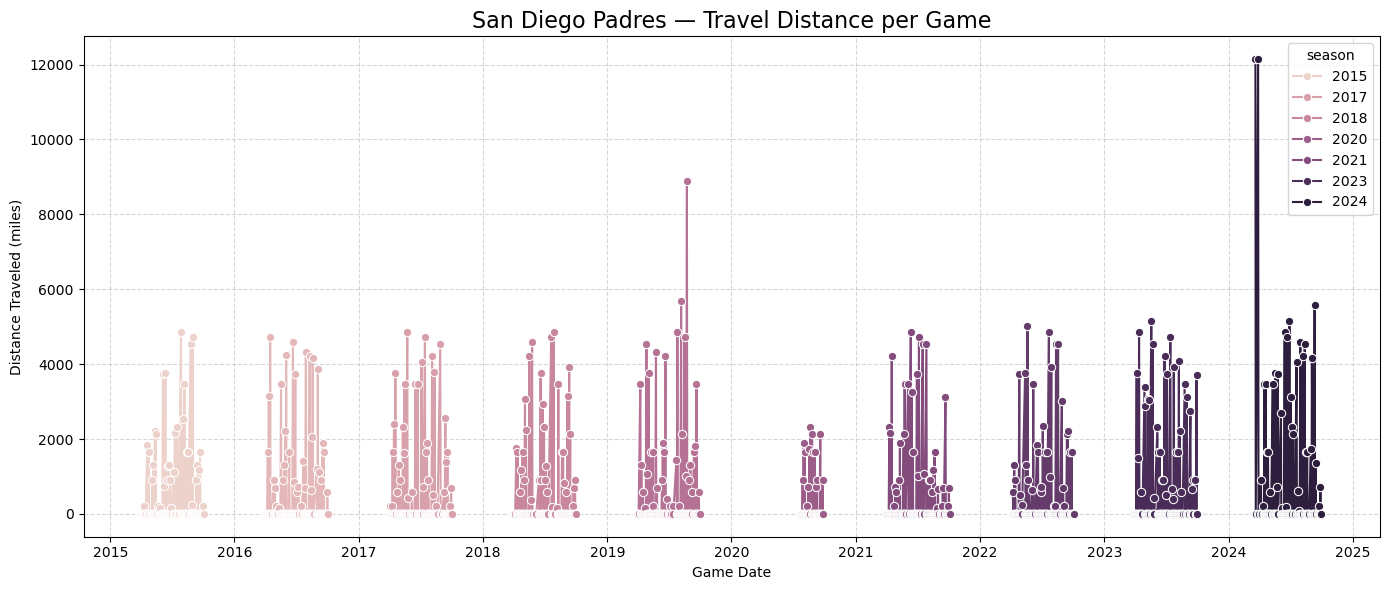

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=padres_df,
    x="game_date",
    y="team_leg_miles",
    hue="season",
    marker="o"
)

plt.title("San Diego Padres — Travel Distance per Game", fontsize=16)
plt.xlabel("Game Date")
plt.ylabel("Distance Traveled (miles)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [81]:
padres_2024 = df[
    (df["tracked_team"] == "San Diego Padres") &
    (df["season"] == 2024)
].copy()

padres_2024 = padres_2024.sort_values("game_date")
print(f"✅ Padres 2024 games: {padres_2024.shape[0]}")
padres_2024.head()


✅ Padres 2024 games: 137


game_id  game_date            home_name             away_name  \
9783   745444 2024-03-20     San Diego Padres   Los Angeles Dodgers   
9784   746175 2024-03-21  Los Angeles Dodgers      San Diego Padres   
9785   745445 2024-03-28     San Diego Padres  San Francisco Giants   
9795   745435 2024-03-29     San Diego Padres  San Francisco Giants   
9800   745436 2024-03-30     San Diego Padres  San Francisco Giants   

            venue_name  season      lat       lon  team_leg_miles  \
9783  Gocheok Sky Dome    2024  37.4983  126.8676    12147.417906   
9784  Gocheok Sky Dome    2024  37.4983  126.8676        0.000000   
9785        Petco Park    2024  32.7073 -117.1586    12147.417906   
9795        Petco Park    2024  32.7073 -117.1586        0.000000   
9800        Petco Park    2024  32.7073 -117.1586        0.000000   

      away_leg_miles  home_leg_miles      tracked_team  
9783             0.0    12147.417906  San Diego Padres  
9784             0.0        0.000000  San Diego Padres  
9785             0.0    12147.417906  San Diego Padres  
9795             0.0        0.000000  San Diego Padres  
9800             0.0        0.000000  San Diego Padres

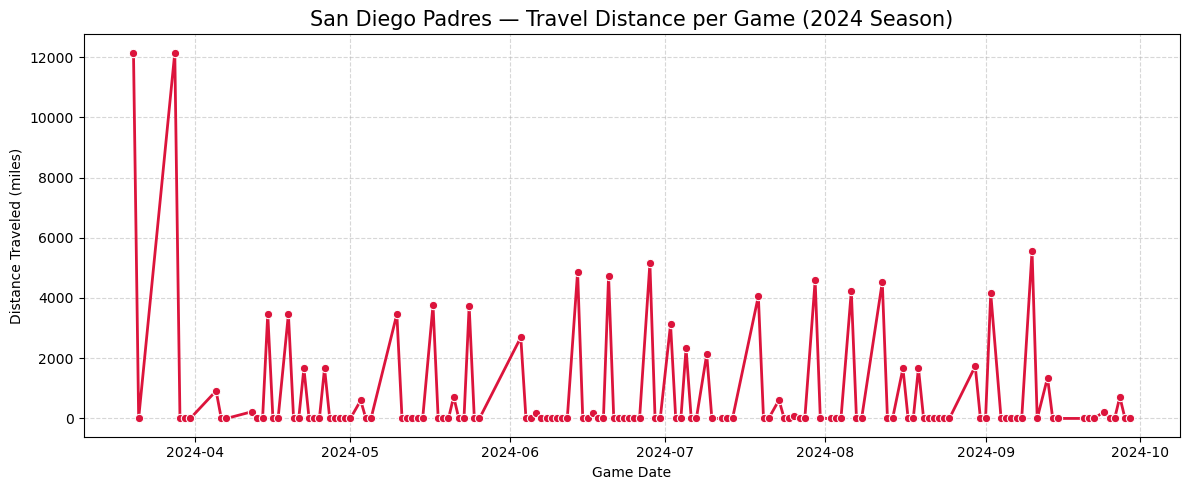

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=padres_2024,
    x="game_date",
    y="team_leg_miles",
    marker="o",
    linewidth=2,
    color="crimson"
)

plt.title("San Diego Padres — Travel Distance per Game (2024 Season)", fontsize=15)
plt.xlabel("Game Date")
plt.ylabel("Distance Traveled (miles)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [85]:
padres_2024

game_id  game_date             home_name             away_name  \
9783    745444 2024-03-20      San Diego Padres   Los Angeles Dodgers   
9784    746175 2024-03-21   Los Angeles Dodgers      San Diego Padres   
9785    745445 2024-03-28      San Diego Padres  San Francisco Giants   
9795    745435 2024-03-29      San Diego Padres  San Francisco Giants   
9800    745436 2024-03-30      San Diego Padres  San Francisco Giants   
...        ...        ...                   ...                   ...   
10910   746095 2024-09-25   Los Angeles Dodgers      San Diego Padres   
10914   746088 2024-09-26   Los Angeles Dodgers      San Diego Padres   
10920   747145 2024-09-27  Arizona Diamondbacks      San Diego Padres   
10929   747146 2024-09-28  Arizona Diamondbacks      San Diego Padres   
10934   747147 2024-09-29  Arizona Diamondbacks      San Diego Padres   

             venue_name  season      lat       lon  team_leg_miles  \
9783   Gocheok Sky Dome    2024  37.4983  126.8676    12147.417906   
9784   Gocheok Sky Dome    2024  37.4983  126.8676        0.000000   
9785         Petco Park    2024  32.7073 -117.1586    12147.417906   
9795         Petco Park    2024  32.7073 -117.1586        0.000000   
9800         Petco Park    2024  32.7073 -117.1586        0.000000   
...                 ...     ...      ...       ...             ...   
10910    Dodger Stadium    2024  34.0739 -118.2400        0.000000   
10914    Dodger Stadium    2024  34.0739 -118.2400        0.000000   
10920       Chase Field    2024  33.4455 -112.0667      714.410373   
10929       Chase Field    2024  33.4455 -112.0667        0.000000   
10934       Chase Field    2024  33.4455 -112.0667        0.000000   

       away_leg_miles  home_leg_miles      tracked_team  
9783         0.000000    12147.417906  San Diego Padres  
9784         0.000000        0.000000  San Diego Padres  
9785         0.000000    12147.417906  San Diego Padres  
9795         0.000000        0.000000  San Diego Padres  
9800         0.000000        0.000000  San Diego Padres  
...               ...             ...               ...  
10910        0.000000        0.000000  San Diego Padres  
10914        0.000000        0.000000  San Diego Padres  
10920      714.410373        0.000000  San Diego Padres  
10929        0.000000        0.000000  San Diego Padres  
10934        0.000000        0.000000  San Diego Padres  

[137 rows x 12 columns]

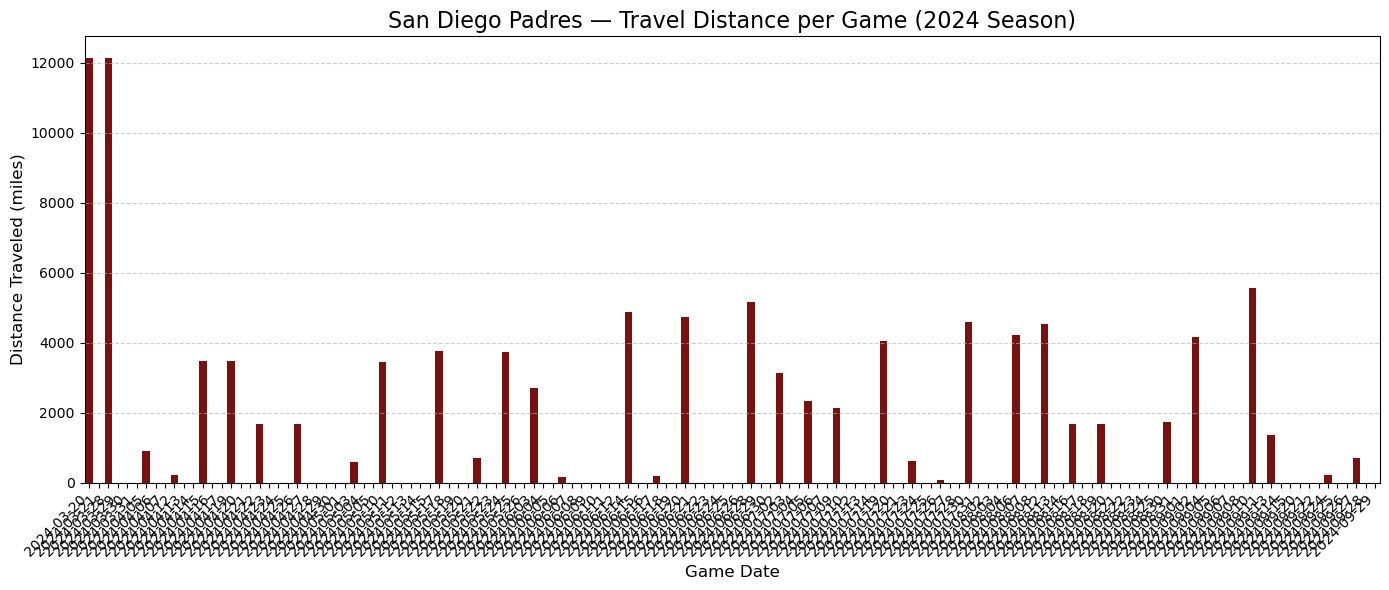

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter and sort Padres 2024 data
padres_2024 = df[
    (df["tracked_team"] == "San Diego Padres") &
    (df["season"] == 2024)
].sort_values("game_date")

plt.figure(figsize=(14, 6))
sns.barplot(
    data=padres_2024,
    x="game_date",
    y="team_leg_miles",
    color="darkred"
)

plt.title("San Diego Padres — Travel Distance per Game (2024 Season)", fontsize=16)
plt.xlabel("Game Date", fontsize=12)
plt.ylabel("Distance Traveled (miles)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


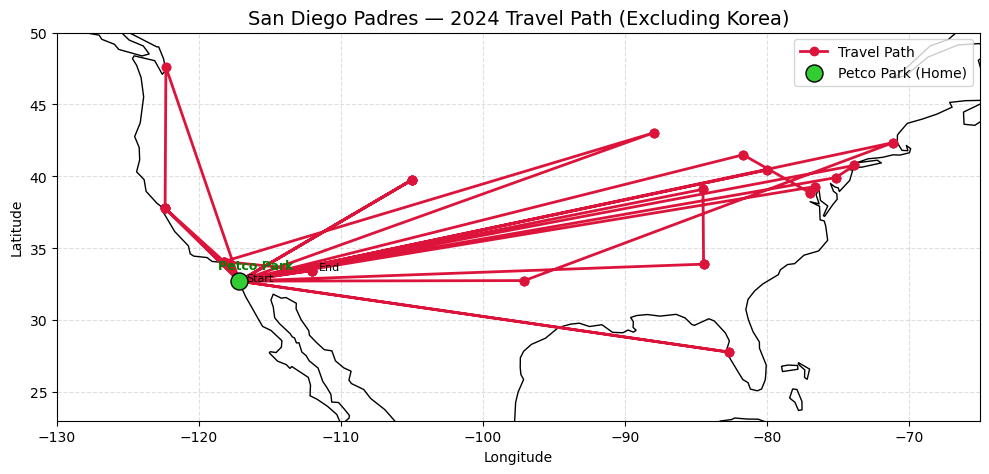

In [111]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------------------
# 1️⃣  Load U.S. map outline
# ---------------------------------------------------------------------
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
usa = world.cx[-130:-60, 23:50]   # roughly continental U.S.

# ---------------------------------------------------------------------
# 2️⃣  Filter Padres 2024 (excluding Korea)
# ---------------------------------------------------------------------
padres_2024_us = (
    df[
        (df["tracked_team"] == "San Diego Padres") &
        (df["season"] == 2024) &
        (df["venue_name"] != "Gocheok Sky Dome")
    ]
    .sort_values("game_date")
    .copy()
)

padres_2024_us = padres_2024_us.dropna(subset=["lat", "lon"])
lats = padres_2024_us["lat"].to_numpy()
lons = padres_2024_us["lon"].to_numpy()

home_lat, home_lon = VENUE_COORDS["Petco Park"]

# ---------------------------------------------------------------------
# 3️⃣  Plot Padres travel over U.S. outline
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 7))

usa.boundary.plot(ax=ax, color="black", linewidth=1.0)

ax.plot(lons, lats, color="crimson", linewidth=2, marker="o", label="Travel Path")

# Home marker
ax.scatter(home_lon, home_lat, color="limegreen", s=150, edgecolor="black", zorder=5, label="Petco Park (Home)")
ax.text(home_lon - 1.5, home_lat + 0.8, "Petco Park", fontsize=9, weight="bold", color="green")

# Start / End labels
ax.text(lons[0] + 0.5, lats[0], "Start", fontsize=8)
ax.text(lons[-1] + 0.5, lats[-1], "End", fontsize=8)

ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("San Diego Padres — 2024 Travel Path (Excluding Korea)", fontsize=14)
ax.legend(loc="upper right")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


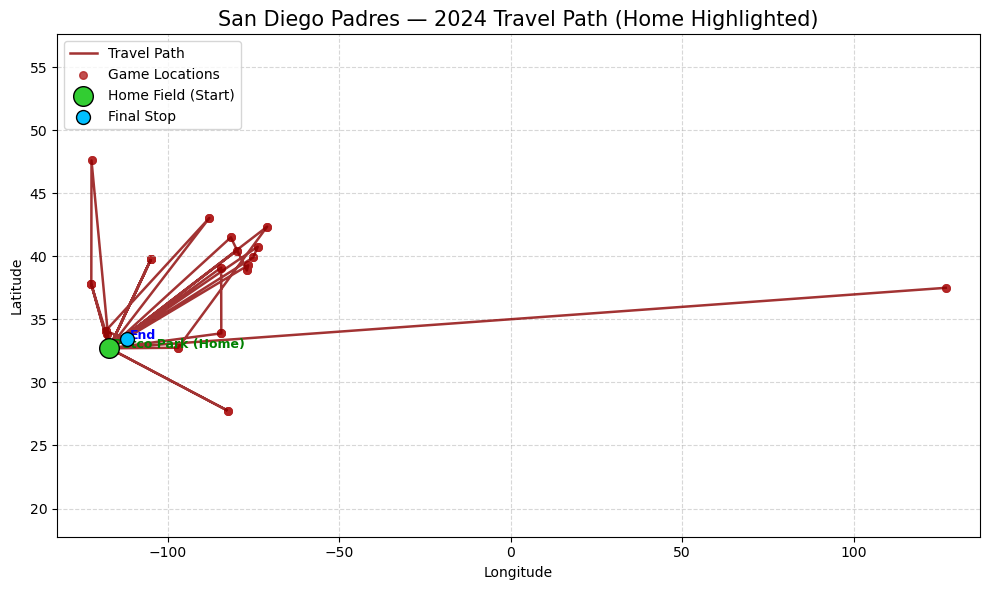

In [93]:
import matplotlib.pyplot as plt

# Filter Padres 2024 games
padres_2024 = (
    df[(df["tracked_team"] == "San Diego Padres") & (df["season"] == 2024)]
    .sort_values("game_date")
    .copy()
)

# Coordinates for travel path
lats = padres_2024["lat"].values
lons = padres_2024["lon"].values

# Get home field (Petco Park) coordinates
home_lat, home_lon = VENUE_COORDS["Petco Park"]

# Make the plot
plt.figure(figsize=(10, 6))
plt.plot(lons, lats, color="darkred", linewidth=1.8, alpha=0.8, label="Travel Path")
plt.scatter(lons, lats, color="firebrick", s=30, alpha=0.8, label="Game Locations")

# Highlight starting home field
plt.scatter(home_lon, home_lat, color="limegreen", s=200, edgecolor="black", zorder=5, label="Home Field (Start)")
plt.text(home_lon + 1, home_lat, "Petco Park (Home)", fontsize=9, weight="bold", color="green")

# Highlight final location
plt.scatter(lons[-1], lats[-1], color="deepskyblue", s=100, edgecolor="black", zorder=5, label="Final Stop")
plt.text(lons[-1] + 1, lats[-1], "End", fontsize=9, weight="bold", color="blue")

# Style the map
plt.title("San Diego Padres — 2024 Travel Path (Home Highlighted)", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper left", frameon=True)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlim(min(lons) - 10, max(lons) + 10)
plt.ylim(min(lats) - 10, max(lats) + 10)
plt.tight_layout()
plt.show()


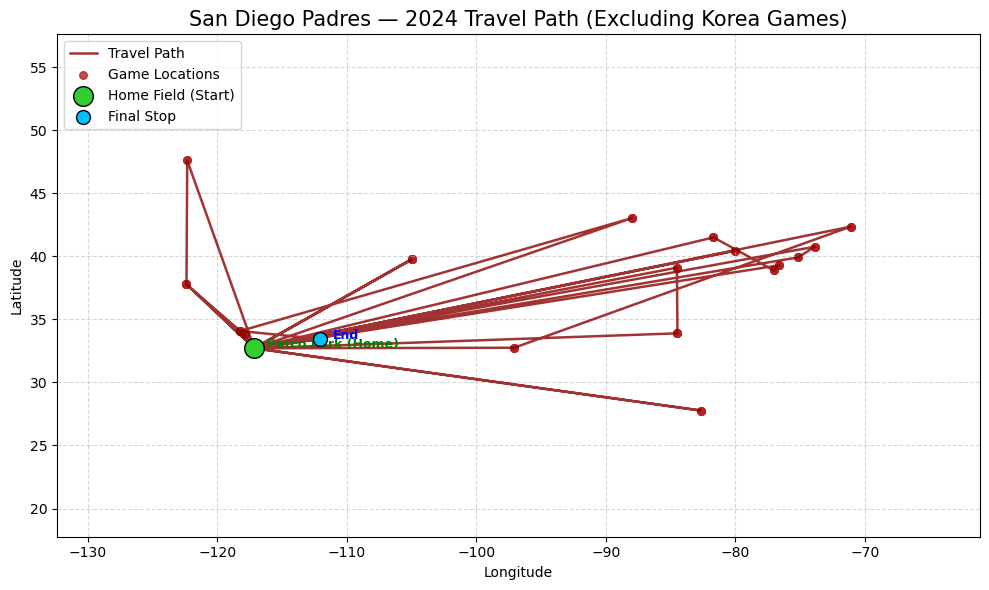

In [95]:
import matplotlib.pyplot as plt

# Filter Padres 2024 games, excluding Seoul / Gocheok Sky Dome
padres_2024 = (
    df[
        (df["tracked_team"] == "San Diego Padres") &
        (df["season"] == 2024) &
        (df["venue_name"] != "Gocheok Sky Dome")
    ]
    .sort_values("game_date")
    .copy()
)

# Coordinates for travel path
lats = padres_2024["lat"].values
lons = padres_2024["lon"].values

# Padres home park
home_lat, home_lon = VENUE_COORDS["Petco Park"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lons, lats, color="darkred", linewidth=1.8, alpha=0.8, label="Travel Path")
plt.scatter(lons, lats, color="firebrick", s=30, alpha=0.8, label="Game Locations")

# Highlight Petco Park
plt.scatter(home_lon, home_lat, color="limegreen", s=200, edgecolor="black", zorder=5, label="Home Field (Start)")
plt.text(home_lon + 1, home_lat, "Petco Park (Home)", fontsize=9, weight="bold", color="green")

# Highlight final stop
plt.scatter(lons[-1], lats[-1], color="deepskyblue", s=100, edgecolor="black", zorder=5, label="Final Stop")
plt.text(lons[-1] + 1, lats[-1], "End", fontsize=9, weight="bold", color="blue")

# Style
plt.title("San Diego Padres — 2024 Travel Path (Excluding Korea Games)", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper left", frameon=True)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlim(min(lons) - 10, max(lons) + 10)
plt.ylim(min(lats) - 10, max(lats) + 10)
plt.tight_layout()
plt.show()


Rows: 135


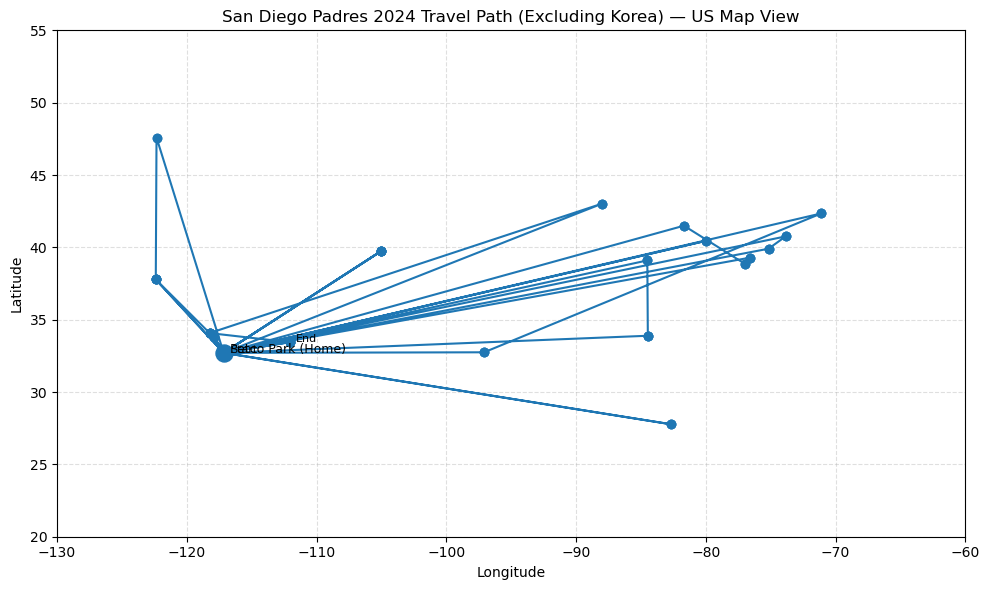

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Filter Padres 2024, tracked rows, exclude Korea
padres_2024_us = (
    df[
        (df["tracked_team"] == "San Diego Padres") &
        (df["season"] == 2024) &
        (df["venue_name"] != "Gocheok Sky Dome")
    ]
    .sort_values("game_date")
    .copy()
)

# 2. Drop any rows missing coords
padres_2024_us = padres_2024_us.dropna(subset=["lat", "lon"])

# Safety check
print("Rows:", len(padres_2024_us))
if len(padres_2024_us) == 0:
    raise ValueError("No Padres 2024 rows found. Check tracked_team / season logic.")

# 3. Extract coords in order
lats = padres_2024_us["lat"].to_numpy()
lons = padres_2024_us["lon"].to_numpy()

# 4. Get Petco Park coords from VENUE_COORDS
home_lat, home_lon = VENUE_COORDS["Petco Park"]

# 5. Plot on a US-bounds map
plt.figure(figsize=(10, 6))

# travel path
plt.plot(lons, lats, marker='o')

# highlight Petco (home/start)
plt.scatter(home_lon, home_lat, s=150)
plt.text(home_lon + 0.5, home_lat, "Petco Park (Home)", fontsize=9)

# mark first & last game locations
plt.text(lons[0] + 0.5, lats[0], "Start", fontsize=8)
plt.text(lons[-1] + 0.5, lats[-1], "End", fontsize=8)

# US-ish bounding box
plt.xlim(-130, -60)
plt.ylim(20, 55)

plt.title("San Diego Padres 2024 Travel Path (Excluding Korea) — US Map View")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [115]:
from pybaseball import schedule_and_record
import pandas as pd

years = range(2015, 2025)
teams = ['BOS', 'SEA', 'SDP', 'MIA', 'CHC', 'STL', 'KCR', 'HOU']

dfs = []
for team in teams:
    for yr in years:
        try:
            df = schedule_and_record(team, yr)
            df['season'] = yr
            dfs.append(df)
        except:
            continue

scores = pd.concat(dfs)
scores.to_csv('mlb_scores_2015_2024.csv', index=False)


ValueError: No objects to concatenate

In [123]:
from pybaseball import schedule_and_record
import pandas as pd

teams = ['BOS', 'SEA', 'SDN', 'MIA', 'CHN', 'SLN', 'KCA', 'HOU']  # Retrosheet-style
years = range(2015, 2025)

dfs = []

for team in teams:
    for yr in years:
        try:
            print(f"Fetching {team} {yr} ...")
            df_tmp = schedule_and_record(yr, team)  # <-- order fixed

            if df_tmp is not None and not df_tmp.empty:
                df_tmp["team"] = team
                df_tmp["season"] = yr
                dfs.append(df_tmp)
            else:
                print(f"Empty for {team} {yr}")
        except Exception as e:
            print(f"Failed for {team} {yr}: {e}")

if not dfs:
    raise RuntimeError("No data pulled. Check abbreviations or network.")

scores = pd.concat(dfs, ignore_index=True)
print(f"✅ Collected {scores.shape[0]} games total.")
scores.to_csv("mlb_scores_2015_2024.csv", index=False)


Fetching BOS 2015 ...
http://www.baseball-reference.com/teams/BOS/2015-schedule-scores.shtml
Failed for BOS 2015: Data cannot be retrieved for this team/year combo. Please verify that your team abbreviation is accurate and that the team existed during the season you are searching for.
Fetching BOS 2016 ...
http://www.baseball-reference.com/teams/BOS/2016-schedule-scores.shtml
Failed for BOS 2016: Data cannot be retrieved for this team/year combo. Please verify that your team abbreviation is accurate and that the team existed during the season you are searching for.
Fetching BOS 2017 ...
http://www.baseball-reference.com/teams/BOS/2017-schedule-scores.shtml


KeyboardInterrupt: 

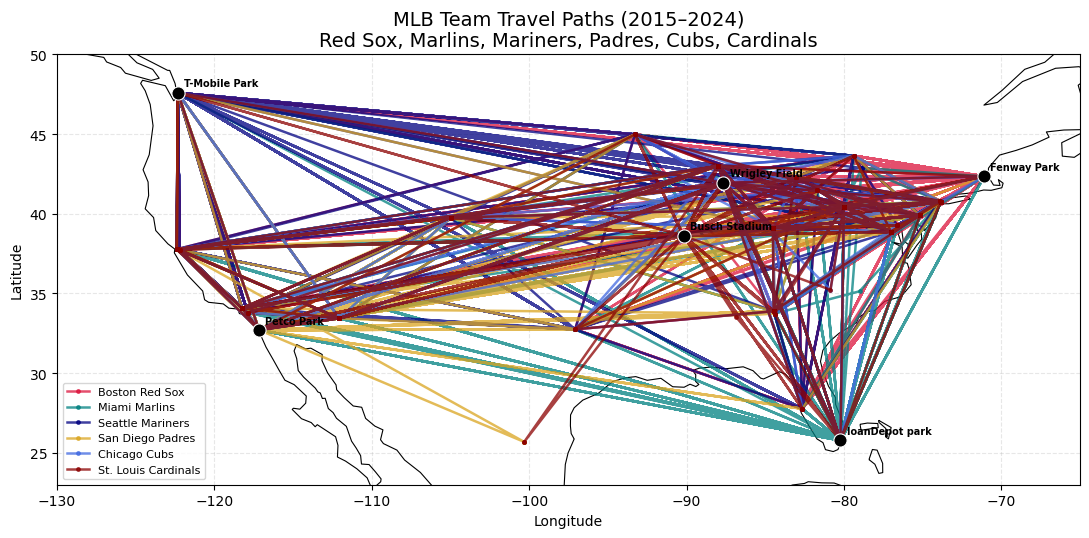

In [125]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1️⃣  U.S. base map
# ---------------------------------------------------------
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
usa = world.cx[-130:-60, 23:50]   # continental U.S.

# ---------------------------------------------------------
# 2️⃣  Team config (names, colors, home parks)
# ---------------------------------------------------------
TEAM_CONFIG = {
    "Boston Red Sox": {
        "color": "crimson",
        "home_venue": "Fenway Park",
    },
    "Miami Marlins": {
        "color": "teal",
        "home_venue": "loanDepot park",  # adjust if your VENUE_COORDS key differs
    },
    "Seattle Mariners": {
        "color": "navy",
        "home_venue": "T-Mobile Park",
    },
    "San Diego Padres": {
        "color": "goldenrod",
        "home_venue": "Petco Park",
    },
    "Chicago Cubs": {
        "color": "royalblue",
        "home_venue": "Wrigley Field",
    },
    "St. Louis Cardinals": {
        "color": "darkred",
        "home_venue": "Busch Stadium",
    },
}

# ---------------------------------------------------------
# 3️⃣  Figure + base map
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 8))

usa.boundary.plot(ax=ax, color="black", linewidth=0.8)

# ---------------------------------------------------------
# 4️⃣  Loop through teams & seasons, plot travel paths
# ---------------------------------------------------------
for team_name, cfg in TEAM_CONFIG.items():
    # subset: team + seasons 2015-2024
    team_df = (
        df[
            (df["tracked_team"] == team_name) &
            (df["season"].between(2015, 2024))
        ]
        .dropna(subset=["lat", "lon"])
        .sort_values("game_date")
        .copy()
    )

    # filter to continental US bounds (kill Korea/Mexico/London/etc)
    team_df = team_df[
        (team_df["lon"] >= -130) & (team_df["lon"] <= -60) &
        (team_df["lat"] >= 23) & (team_df["lat"] <= 50)
    ]

    if team_df.empty:
        print(f"No valid US data for {team_name}, skipping.")
        continue

    lats = team_df["lat"].to_numpy()
    lons = team_df["lon"].to_numpy()

    # plot travel path for this team
    ax.plot(
        lons,
        lats,
        linewidth=1.8,
        marker="o",
        markersize=2.5,
        color=cfg["color"],
        alpha=0.75,
        label=team_name,
    )

    # home park marker (start anchor)
    home_venue = cfg["home_venue"]
    if home_venue not in VENUE_COORDS:
        print(f"Missing home coords for {team_name}: {home_venue}")
        continue

    home_lat, home_lon = VENUE_COORDS[home_venue]

    ax.scatter(
        home_lon,
        home_lat,
        s=90,
        color="black",
        edgecolor="white",
        linewidth=0.8,
        zorder=5,
    )

    ax.text(
        home_lon + 0.4,
        home_lat + 0.4,
        home_venue,
        fontsize=7,
        fontweight="bold",
        color="black",
        zorder=6,
    )

# ---------------------------------------------------------
# 5️⃣  Final styling
# ---------------------------------------------------------
ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("MLB Team Travel Paths (2015–2024)\nRed Sox, Marlins, Mariners, Padres, Cubs, Cardinals", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.3)

# one legend for all teams
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="lower left", fontsize=8, frameon=True)

plt.tight_layout()
plt.show()


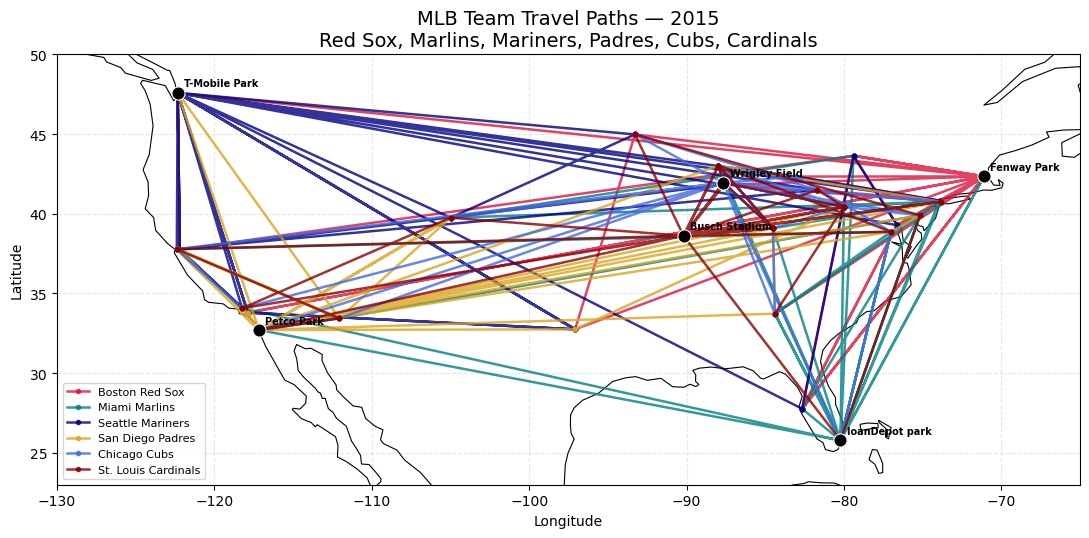

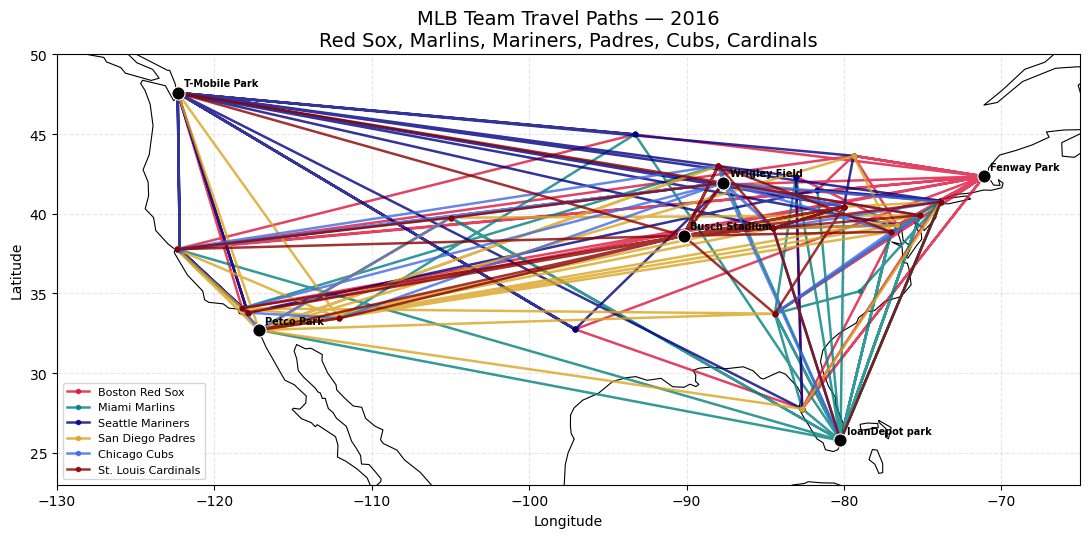

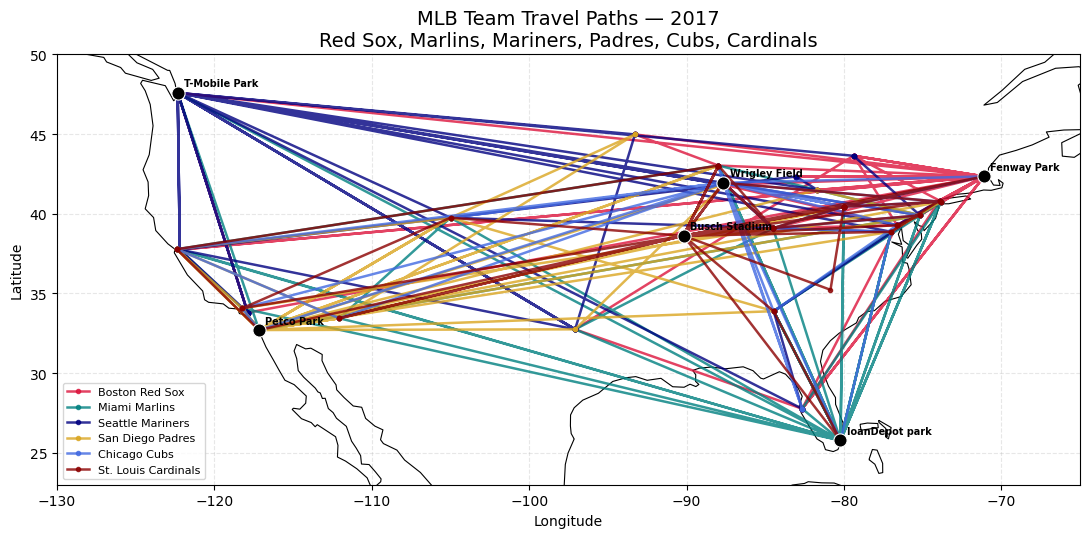

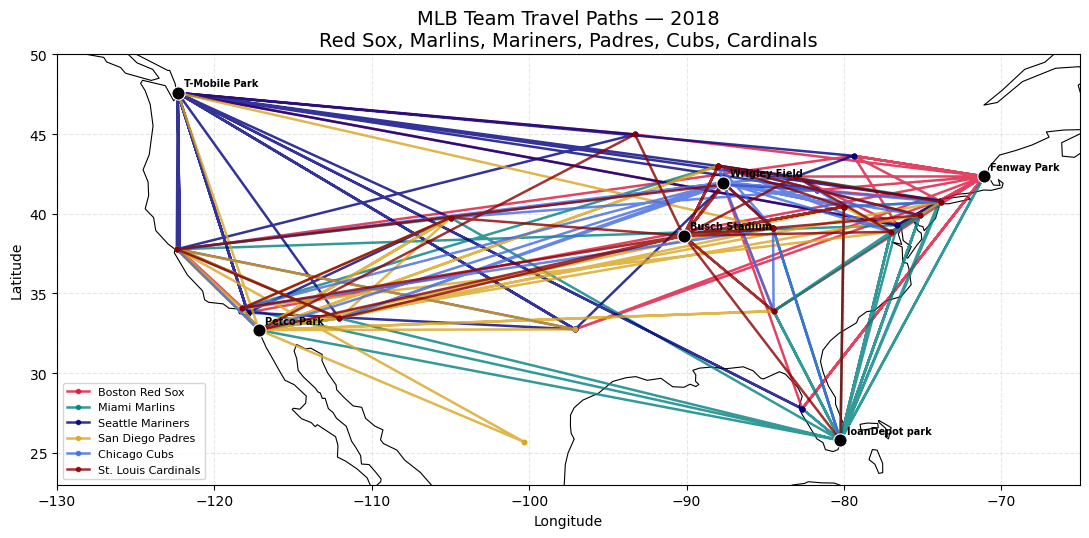

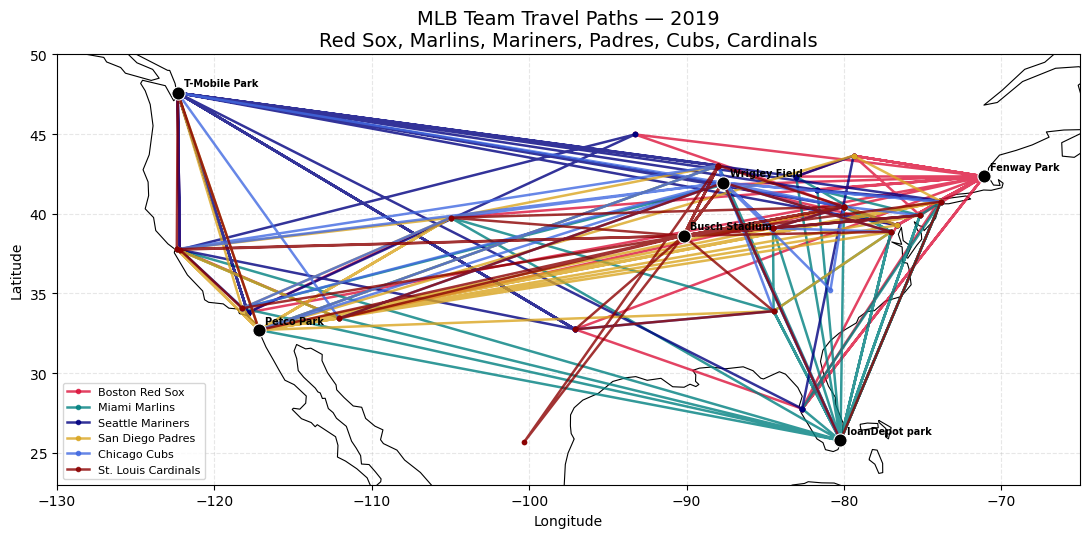

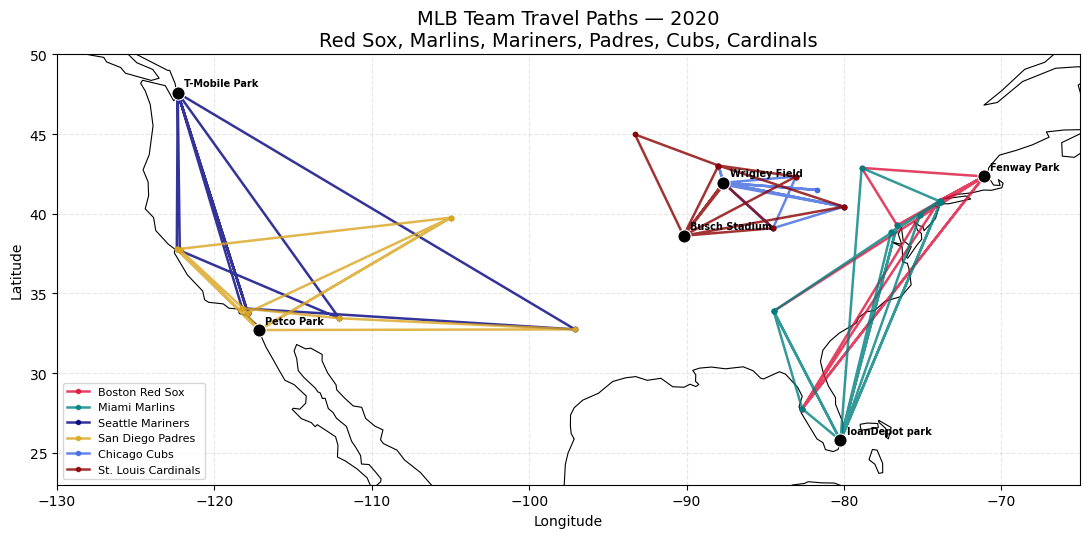

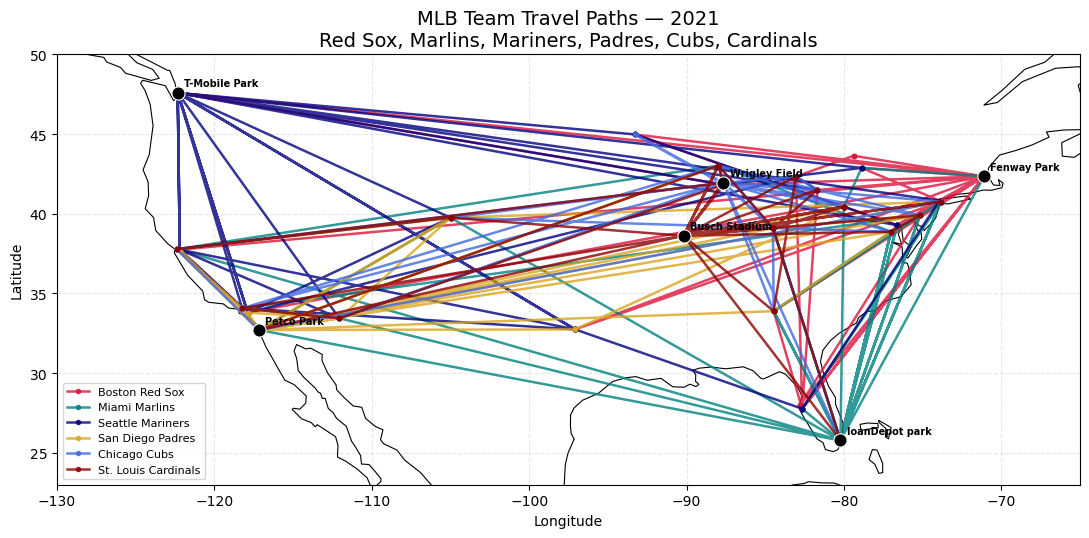

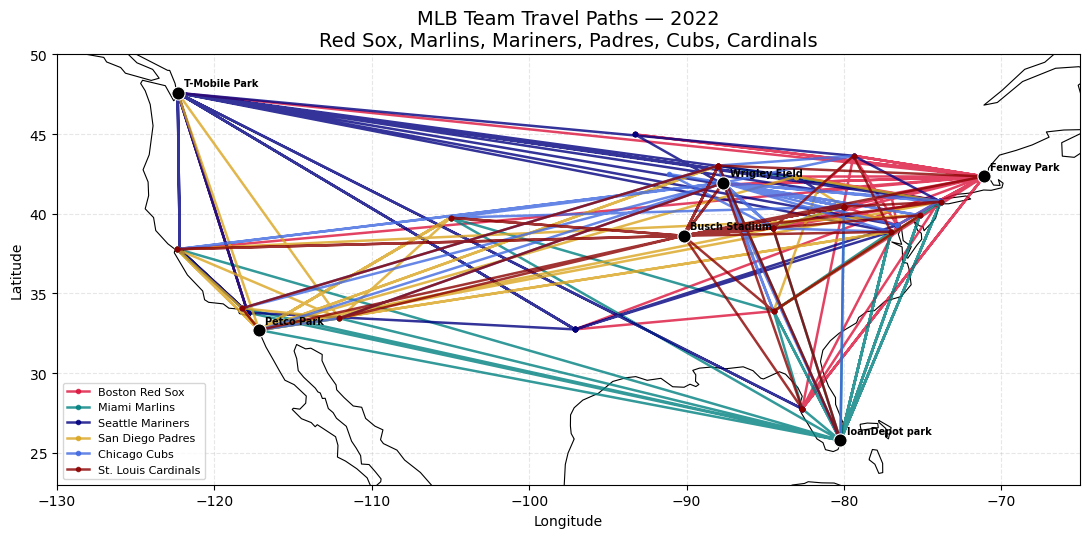

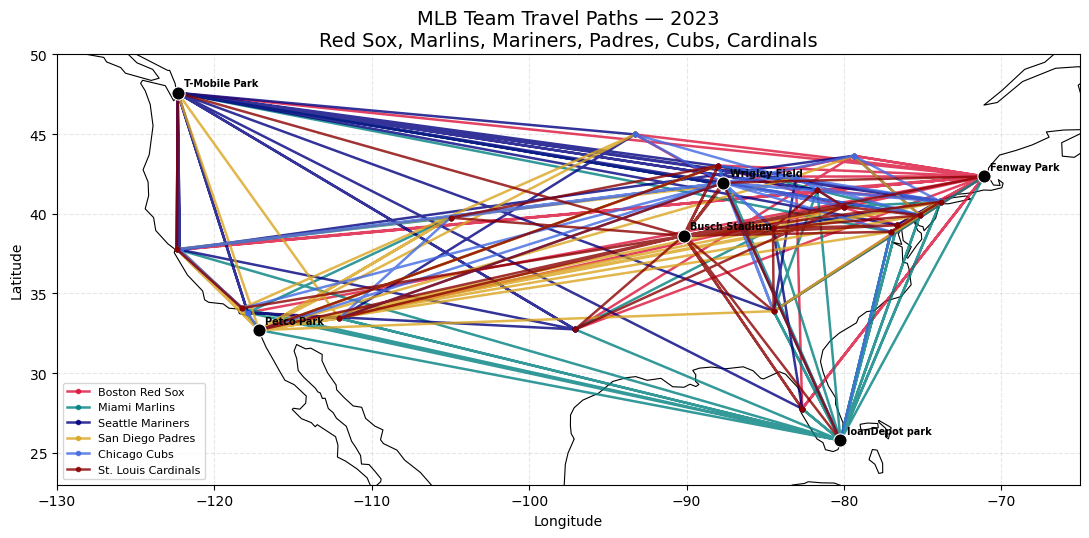

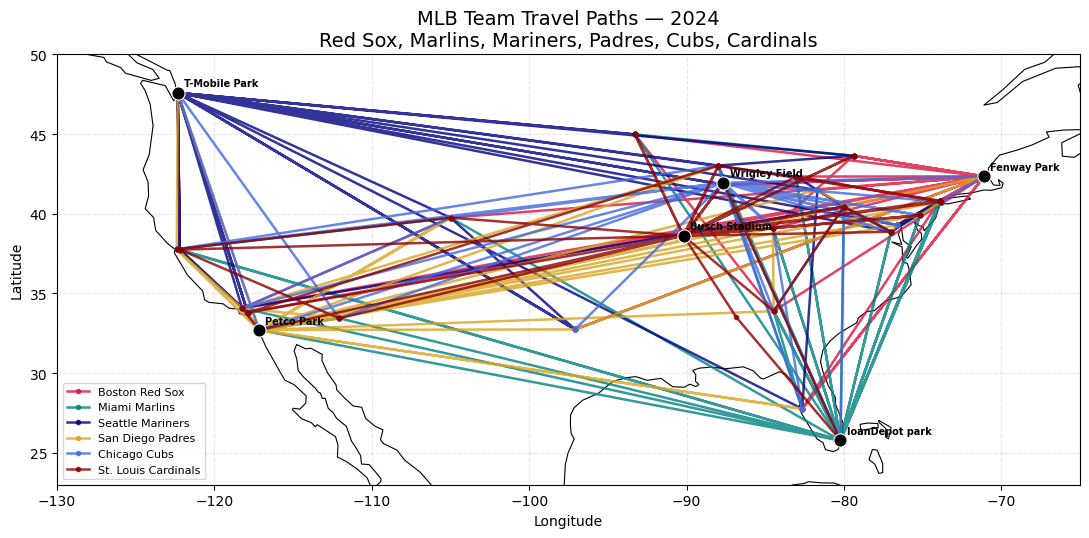

In [127]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Base map (load once)
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
usa = world.cx[-130:-60, 23:50]   # continental U.S.

# 2️⃣ Team config
TEAM_CONFIG = {
    "Boston Red Sox": {
        "color": "crimson",
        "home_venue": "Fenway Park",
    },
    "Miami Marlins": {
        "color": "teal",
        "home_venue": "loanDepot park",  # adjust if key differs
    },
    "Seattle Mariners": {
        "color": "navy",
        "home_venue": "T-Mobile Park",
    },
    "San Diego Padres": {
        "color": "goldenrod",
        "home_venue": "Petco Park",
    },
    "Chicago Cubs": {
        "color": "royalblue",
        "home_venue": "Wrigley Field",
    },
    "St. Louis Cardinals": {
        "color": "darkred",
        "home_venue": "Busch Stadium",
    },
}

years = range(2015, 2025)

for yr in years:
    fig, ax = plt.subplots(figsize=(11, 8))

    # base map
    usa.boundary.plot(ax=ax, color="black", linewidth=0.8)

    handles_labels = {}

    for team_name, cfg in TEAM_CONFIG.items():
        # subset by team + year
        team_df = (
            df[
                (df["tracked_team"] == team_name) &
                (df["season"] == yr)
            ]
            .dropna(subset=["lat", "lon"])
            .sort_values("game_date")
            .copy()
        )

        # filter to continental US (drop Korea/Mexico/London, etc.)
        team_df = team_df[
            (team_df["lon"] >= -130) & (team_df["lon"] <= -60) &
            (team_df["lat"] >= 23) & (team_df["lat"] <= 50)
        ]

        if team_df.empty:
            continue

        lats = team_df["lat"].to_numpy()
        lons = team_df["lon"].to_numpy()

        # travel path for that year
        line, = ax.plot(
            lons,
            lats,
            linewidth=1.8,
            marker="o",
            markersize=3,
            color=cfg["color"],
            alpha=0.8,
            label=team_name,
        )

        handles_labels[team_name] = line

        # home marker
        home_venue = cfg["home_venue"]
        if home_venue in VENUE_COORDS:
            home_lat, home_lon = VENUE_COORDS[home_venue]

            ax.scatter(
                home_lon,
                home_lat,
                s=90,
                color="black",
                edgecolor="white",
                linewidth=0.8,
                zorder=5,
            )

            ax.text(
                home_lon + 0.4,
                home_lat + 0.4,
                home_venue,
                fontsize=7,
                fontweight="bold",
                color="black",
                zorder=6,
            )

    ax.set_xlim(-130, -65)
    ax.set_ylim(23, 50)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"MLB Team Travel Paths — {yr}\nRed Sox, Marlins, Mariners, Padres, Cubs, Cardinals",
                 fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.3)

    if handles_labels:
        ax.legend(
            handles_labels.values(),
            handles_labels.keys(),
            loc="lower left",
            fontsize=8,
            frameon=True,
        )

    plt.tight_layout()
    plt.show()


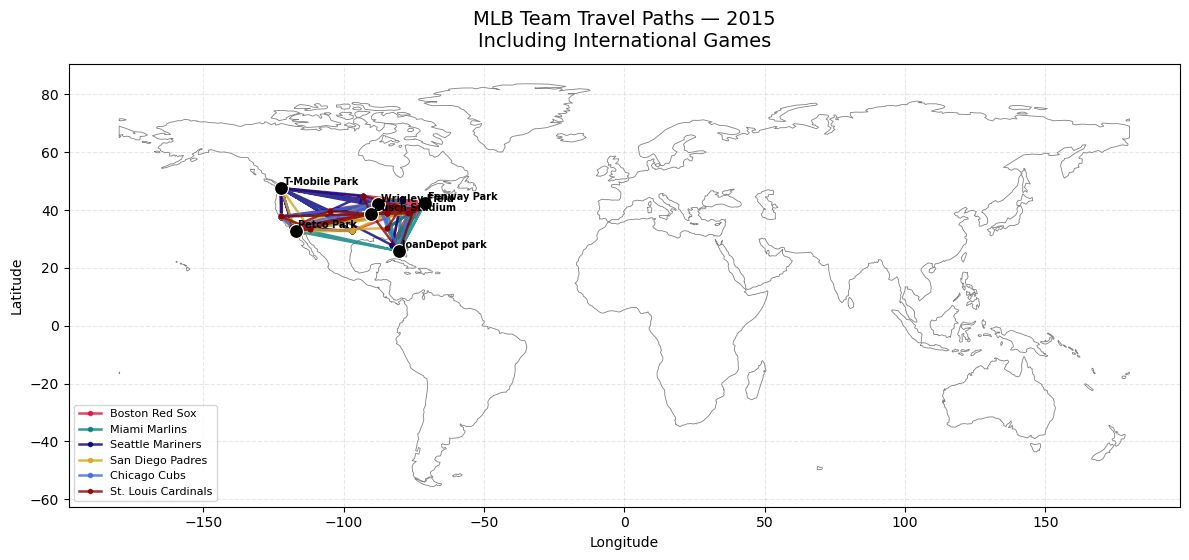

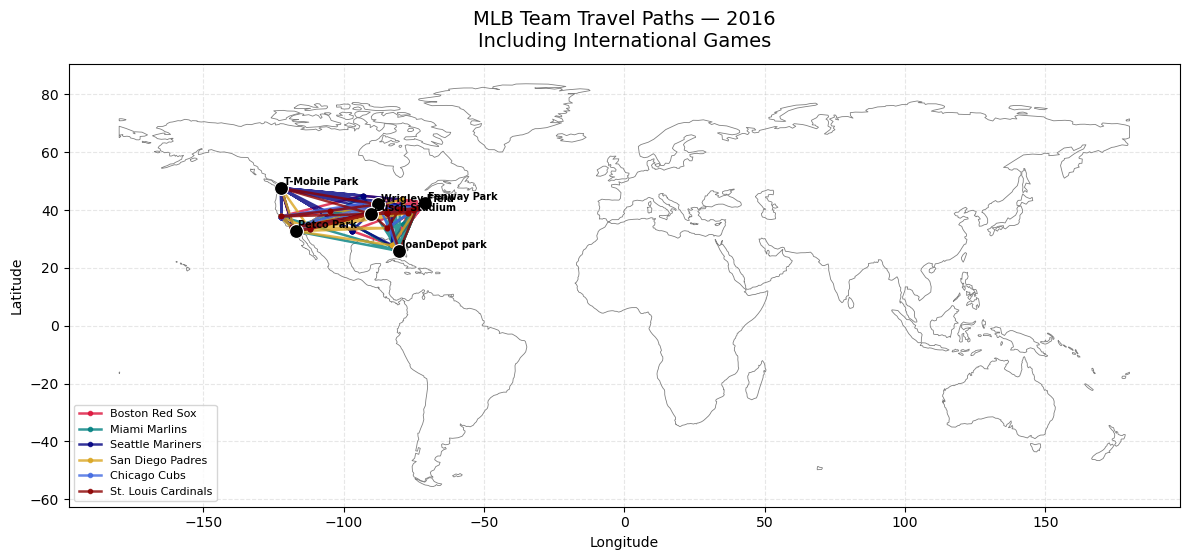

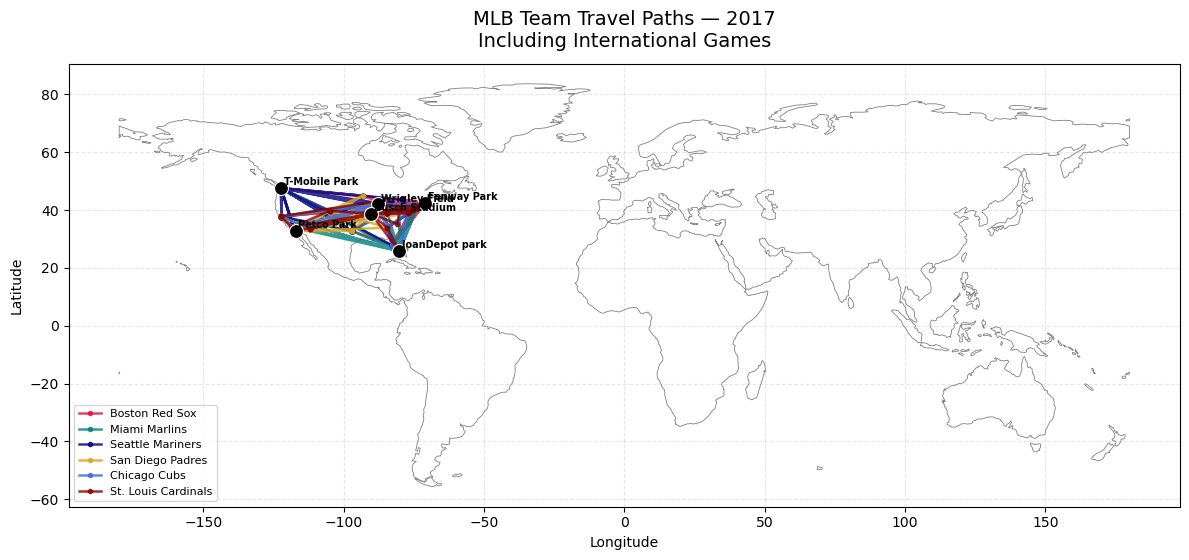

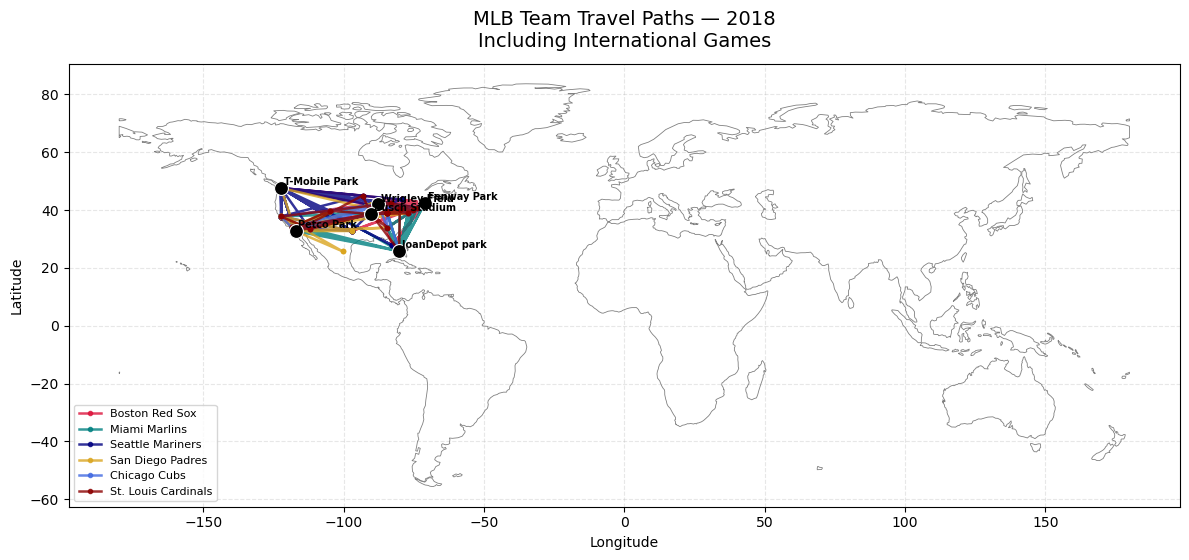

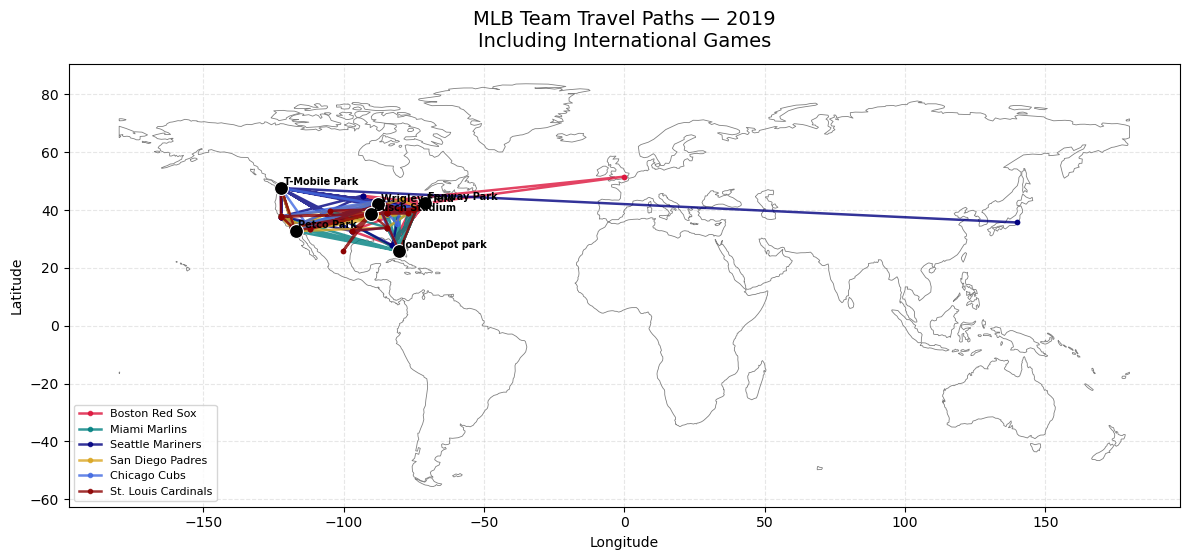

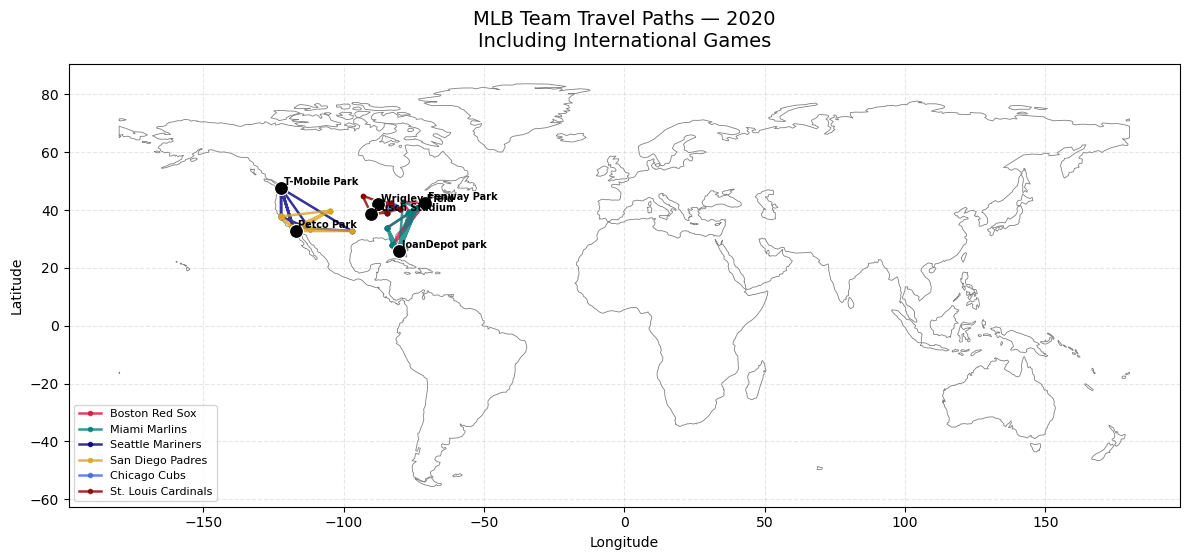

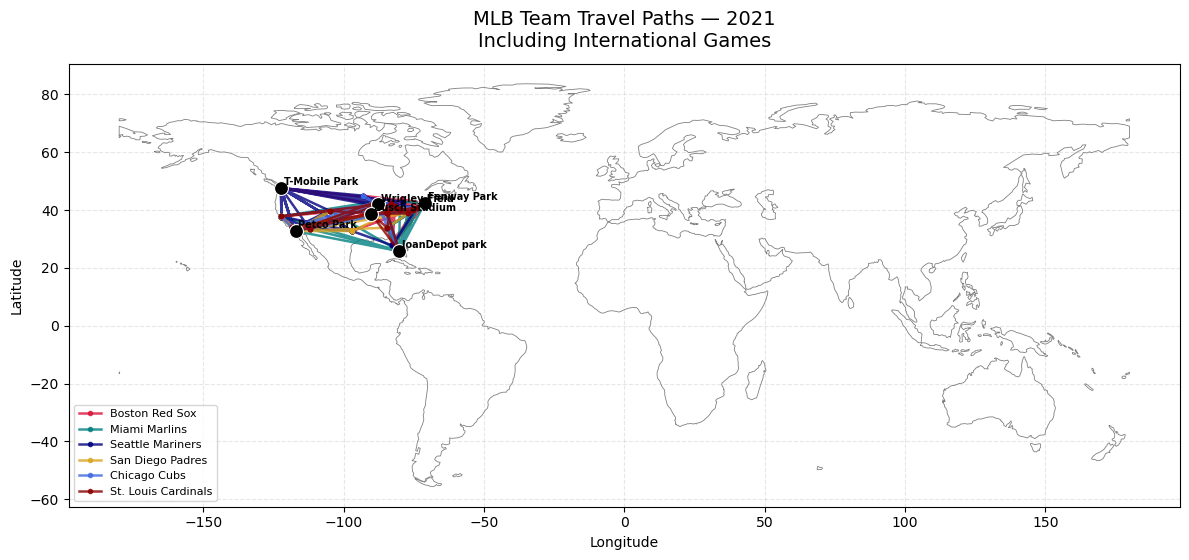

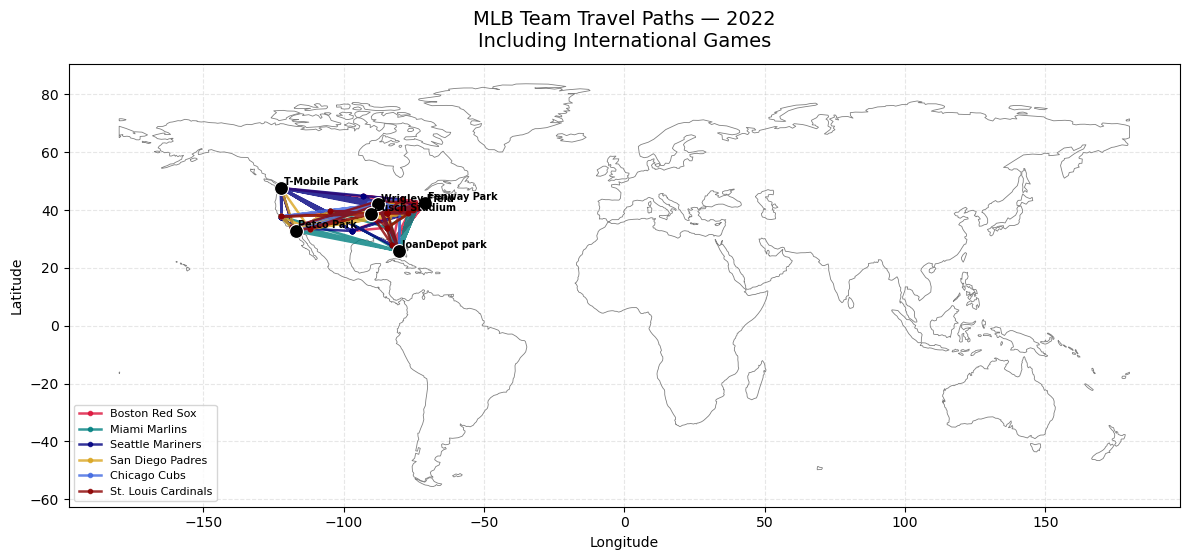

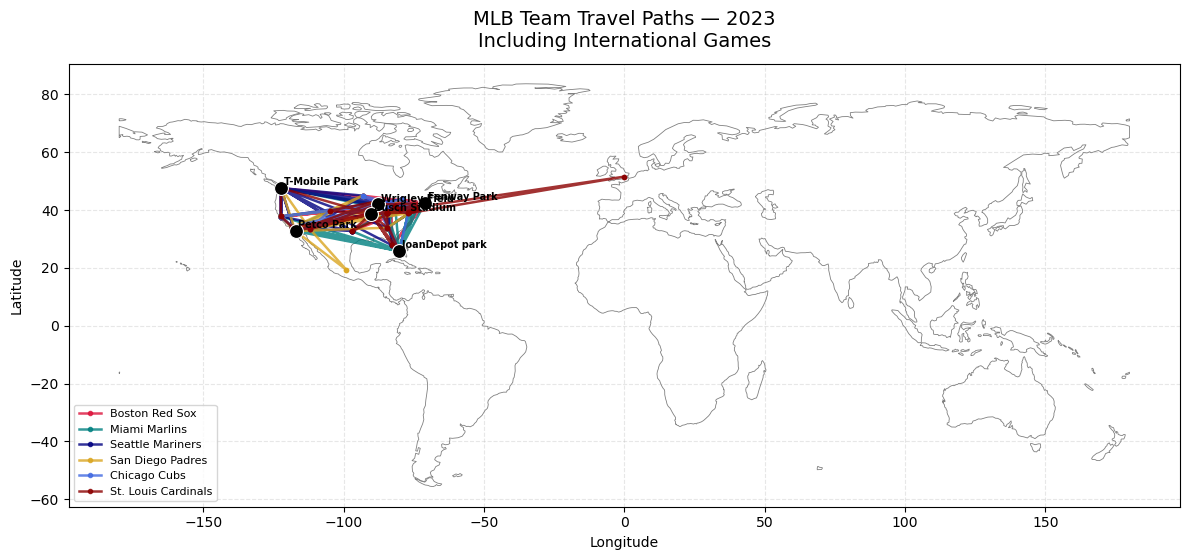

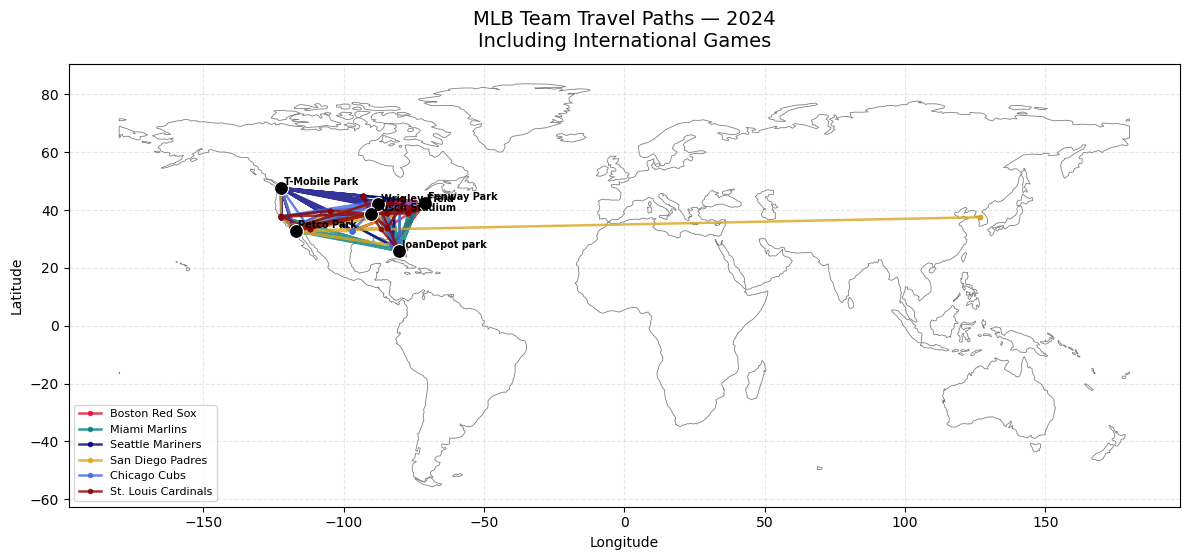

In [129]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------
# 1️⃣ Load base world map
# -----------------------------------------------------
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# focus on a global-ish view that shows MLB + intl trips
world_extent = world.cx[-180:180, -60:75]

# -----------------------------------------------------
# 2️⃣ Team configuration (color + home field)
# -----------------------------------------------------
TEAM_CONFIG = {
    "Boston Red Sox": {
        "color": "crimson",
        "home_venue": "Fenway Park",
    },
    "Miami Marlins": {
        "color": "teal",
        "home_venue": "loanDepot park",
    },
    "Seattle Mariners": {
        "color": "navy",
        "home_venue": "T-Mobile Park",
    },
    "San Diego Padres": {
        "color": "goldenrod",
        "home_venue": "Petco Park",
    },
    "Chicago Cubs": {
        "color": "royalblue",
        "home_venue": "Wrigley Field",
    },
    "St. Louis Cardinals": {
        "color": "darkred",
        "home_venue": "Busch Stadium",
    },
}

years = range(2015, 2025)

# -----------------------------------------------------
# 3️⃣ Loop through each season
# -----------------------------------------------------
for yr in years:
    fig, ax = plt.subplots(figsize=(12, 7))

    # draw base map
    world_extent.boundary.plot(ax=ax, color="gray", linewidth=0.6)

    handles_labels = {}

    for team_name, cfg in TEAM_CONFIG.items():
        team_df = (
            df[
                (df["tracked_team"] == team_name)
                & (df["season"] == yr)
            ]
            .dropna(subset=["lat", "lon"])
            .sort_values("game_date")
            .copy()
        )

        if team_df.empty:
            continue

        lats = team_df["lat"].to_numpy()
        lons = team_df["lon"].to_numpy()

        # plot travel path
        line, = ax.plot(
            lons,
            lats,
            linewidth=1.8,
            marker="o",
            markersize=3,
            color=cfg["color"],
            alpha=0.8,
            label=team_name,
        )
        handles_labels[team_name] = line

        # home park marker
        home_venue = cfg["home_venue"]
        if home_venue in VENUE_COORDS:
            home_lat, home_lon = VENUE_COORDS[home_venue]

            ax.scatter(
                home_lon,
                home_lat,
                s=100,
                color="black",
                edgecolor="white",
                linewidth=0.8,
                zorder=5,
            )
            ax.text(
                home_lon + 1,
                home_lat + 1,
                home_venue,
                fontsize=7,
                fontweight="bold",
                color="black",
                zorder=6,
            )

    # -----------------------------------------------------
    # 4️⃣ Styling
    # -----------------------------------------------------
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"MLB Team Travel Paths — {yr}\nIncluding International Games",
                 fontsize=14, pad=12)
    ax.grid(True, linestyle="--", alpha=0.3)

    if handles_labels:
        ax.legend(
            handles_labels.values(),
            handles_labels.keys(),
            loc="lower left",
            fontsize=8,
            frameon=True,
        )

    plt.tight_layout()
    plt.show()


In [131]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# -----------------------------------------------------
# 1️⃣ Load base world + U.S. maps
# -----------------------------------------------------
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
usa = world.cx[-130:-60, 23:50]   # continental U.S.

# -----------------------------------------------------
# 2️⃣ Team config (color + home venue)
# -----------------------------------------------------
TEAM_CONFIG = {
    "Boston Red Sox": {"color": "crimson", "home_venue": "Fenway Park"},
    "Miami Marlins": {"color": "teal", "home_venue": "loanDepot park"},
    "Seattle Mariners": {"color": "navy", "home_venue": "T-Mobile Park"},
    "San Diego Padres": {"color": "goldenrod", "home_venue": "Petco Park"},
    "Chicago Cubs": {"color": "royalblue", "home_venue": "Wrigley Field"},
    "St. Louis Cardinals": {"color": "darkred", "home_venue": "Busch Stadium"},
}

years = range(2015, 2025)

# -----------------------------------------------------
# 3️⃣ Separate U.S. and International datasets
# -----------------------------------------------------
us_mask = (
    (df["lon"].between(-130, -60))
    & (df["lat"].between(23, 50))
)

df_us = df[us_mask].copy()
df_intl = df[~us_mask].copy()

# -----------------------------------------------------
# 4️⃣ Helper: function to generate multi-page PDF
# -----------------------------------------------------
def plot_travel_pdf(data, pdf_name, title_prefix, base_map):
    with PdfPages(pdf_name) as pdf:
        for yr in years:
            fig, ax = plt.subplots(figsize=(11, 8))
            base_map.boundary.plot(ax=ax, color="black", linewidth=0.6)

            handles_labels = {}

            for team_name, cfg in TEAM_CONFIG.items():
                team_df = (
                    data[
                        (data["tracked_team"] == team_name)
                        & (data["season"] == yr)
                    ]
                    .dropna(subset=["lat", "lon"])
                    .sort_values("game_date")
                    .copy()
                )

                if team_df.empty:
                    continue

                lats = team_df["lat"].to_numpy()
                lons = team_df["lon"].to_numpy()

                line, = ax.plot(
                    lons,
                    lats,
                    linewidth=1.8,
                    marker="o",
                    markersize=3,
                    color=cfg["color"],
                    alpha=0.8,
                    label=team_name,
                )
                handles_labels[team_name] = line

                # home venue
                home_venue = cfg["home_venue"]
                if home_venue in VENUE_COORDS:
                    home_lat, home_lon = VENUE_COORDS[home_venue]
                    ax.scatter(
                        home_lon,
                        home_lat,
                        s=90,
                        color="black",
                        edgecolor="white",
                        linewidth=0.8,
                        zorder=5,
                    )
                    ax.text(
                        home_lon + 0.5,
                        home_lat + 0.5,
                        home_venue,
                        fontsize=7,
                        fontweight="bold",
                        color="black",
                        zorder=6,
                    )

            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.set_title(f"{title_prefix} Travel Paths — {yr}", fontsize=14)
            ax.grid(True, linestyle="--", alpha=0.3)

            if handles_labels:
                ax.legend(
                    handles_labels.values(),
                    handles_labels.keys(),
                    loc="lower left",
                    fontsize=8,
                    frameon=True,
                )

            plt.tight_layout()
            pdf.savefig(fig, bbox_inches="tight")
            plt.close(fig)

    print(f"✅ Saved {pdf_name}")

# -----------------------------------------------------
# 5️⃣ Generate both PDFs
# -----------------------------------------------------
plot_travel_pdf(df_us, "MLB_US_Travel_2015_2024.pdf", "Continental U.S.", usa)
plot_travel_pdf(df_intl, "MLB_International_Travel_2015_2024.pdf", "International", world)


✅ Saved MLB_US_Travel_2015_2024.pdf
✅ Saved MLB_International_Travel_2015_2024.pdf


In [133]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# ---------- 1. Load continental U.S. base map ----------
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
usa = world.cx[-130:-60, 23:50]   # tight bounds around continental U.S.

# ---------- 2. Team config (names, colors, home venues) ----------
TEAM_CONFIG = {
    "Boston Red Sox":     {"color": "crimson",   "home_venue": "Fenway Park"},
    "Miami Marlins":      {"color": "teal",      "home_venue": "loanDepot park"},
    "Seattle Mariners":   {"color": "navy",      "home_venue": "T-Mobile Park"},
    "San Diego Padres":   {"color": "goldenrod", "home_venue": "Petco Park"},
    "Chicago Cubs":       {"color": "royalblue", "home_venue": "Wrigley Field"},
    "St. Louis Cardinals":{"color": "darkred",   "home_venue": "Busch Stadium"},
}

years = range(2015, 2025)

# ---------- 3. Filter to continental U.S. games only ----------
us_mask = (
    (df["lon"].between(-130, -60)) &
    (df["lat"].between(23, 50))
)

df_us = df[us_mask].copy()

# ---------- 4. Build multi-page PDF for continental U.S. ----------
output_pdf = "MLB_Continental_US_Travel_2015_2024.pdf"

with PdfPages(output_pdf) as pdf:
    for yr in years:
        fig, ax = plt.subplots(figsize=(11, 8))

        # Base map: only continental U.S.
        usa.boundary.plot(ax=ax, color="black", linewidth=0.7)

        handles_labels = {}

        for team_name, cfg in TEAM_CONFIG.items():
            team_df = (
                df_us[
                    (df_us["tracked_team"] == team_name) &
                    (df_us["season"] == yr)
                ]
                .dropna(subset=["lat", "lon"])
                .sort_values("game_date")
                .copy()
            )

            if team_df.empty:
                continue

            lats = team_df["lat"].to_numpy()
            lons = team_df["lon"].to_numpy()

            # Travel path for that team/year
            line, = ax.plot(
                lons,
                lats,
                linewidth=1.8,
                marker="o",
                markersize=3,
                color=cfg["color"],
                alpha=0.8,
                label=team_name,
            )
            handles_labels[team_name] = line

            # Home park marker
            home_venue = cfg["home_venue"]
            if home_venue in VENUE_COORDS:
                home_lat, home_lon = VENUE_COORDS[home_venue]

                # Only mark if inside continental bounds
                if (-130 <= home_lon <= -60) and (23 <= home_lat <= 50):
                    ax.scatter(
                        home_lon,
                        home_lat,
                        s=90,
                        color="black",
                        edgecolor="white",
                        linewidth=0.8,
                        zorder=5,
                    )
                    ax.text(
                        home_lon + 0.5,
                        home_lat + 0.5,
                        home_venue,
                        fontsize=7,
                        fontweight="bold",
                        color="black",
                        zorder=6,
                    )

        ax.set_xlim(-130, -60)
        ax.set_ylim(23, 50)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(
            f"Continental U.S. Travel Paths — {yr}\n"
            "Boston, Miami, Seattle, San Diego, Chicago, St. Louis",
            fontsize=14,
            pad=10,
        )
        ax.grid(True, linestyle="--", alpha=0.3)

        if handles_labels:
            ax.legend(
                handles_labels.values(),
                handles_labels.keys(),
                loc="lower left",
                fontsize=8,
                frameon=True,
            )

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches="tight")
        plt.close(fig)

print(f"Saved {output_pdf}")


Saved MLB_Continental_US_Travel_2015_2024.pdf


In [135]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# 1️⃣ Load world map
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Crop to a useful global extent (covers US + Europe + Asia)
world_extent = world.cx[-180:180, -60:80]

# 2️⃣ Team config
TEAM_CONFIG = {
    "Boston Red Sox":     {"color": "crimson",   "home_venue": "Fenway Park"},
    "Miami Marlins":      {"color": "teal",      "home_venue": "loanDepot park"},
    "Seattle Mariners":   {"color": "navy",      "home_venue": "T-Mobile Park"},
    "San Diego Padres":   {"color": "goldenrod", "home_venue": "Petco Park"},
    "Chicago Cubs":       {"color": "royalblue", "home_venue": "Wrigley Field"},
    "St. Louis Cardinals":{"color": "darkred",   "home_venue": "Busch Stadium"},
}

years = range(2015, 2025)

# 3️⃣ Keep only our six teams, ensure coords exist
df_world = (
    df[df["tracked_team"].isin(TEAM_CONFIG.keys())]
    .dropna(subset=["lat", "lon"])
    .copy()
)

output_pdf_world = "MLB_World_Travel_2015_2024.pdf"

# 4️⃣ Build multi-page world travel PDF
with PdfPages(output_pdf_world) as pdf:
    for yr in years:
        fig, ax = plt.subplots(figsize=(11, 8))

        # base world map
        world_extent.boundary.plot(ax=ax, color="black", linewidth=0.6)

        handles_labels = {}
        any_data = False

        for team_name, cfg in TEAM_CONFIG.items():
            team_df = (
                df_world[
                    (df_world["tracked_team"] == team_name) &
                    (df_world["season"] == yr)
                ]
                .sort_values("game_date")
                .copy()
            )

            if team_df.empty:
                continue

            any_data = True

            lats = team_df["lat"].to_numpy()
            lons = team_df["lon"].to_numpy()

            # travel path
            line, = ax.plot(
                lons,
                lats,
                linewidth=1.8,
                marker="o",
                markersize=3,
                color=cfg["color"],
                alpha=0.85,
                label=team_name,
            )
            handles_labels[team_name] = line

            # home park marker (for context)
            home_venue = cfg["home_venue"]
            if home_venue in VENUE_COORDS:
                home_lat, home_lon = VENUE_COORDS[home_venue]
                ax.scatter(
                    home_lon,
                    home_lat,
                    s=70,
                    color="black",
                    edgecolor="white",
                    linewidth=0.7,
                    zorder=5,
                )

        # if no games that year for selected teams, skip page
        if not any_data:
            plt.close(fig)
            continue

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(
            f"Global Travel Paths — {yr}\n"
            "Boston, Miami, Seattle, San Diego, Chicago, St. Louis",
            fontsize=14,
            pad=10,
        )
        ax.grid(True, linestyle="--", alpha=0.3)

        if handles_labels:
            ax.legend(
                handles_labels.values(),
                handles_labels.keys(),
                loc="lower left",
                fontsize=8,
                frameon=True,
            )

        # world-ish view so all trips show
        ax.set_xlim(-180, 180)
        ax.set_ylim(-60, 80)

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches="tight")
        plt.close(fig)

print(f"✅ Saved {output_pdf_world}")


✅ Saved MLB_World_Travel_2015_2024.pdf
